In [785]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [786]:
processed_csv_path = "EGFR_COSMIC_processed_features.csv"

df_features = pd.read_csv(processed_csv_path)
print(f"Successfully loaded processed DataFrame from: {processed_csv_path}")
print(f"Shape of loaded DataFrame: {df_features.shape}")
print("\nInfo for the loaded DataFrame:")
df_features.info()
print("\nSample of loaded DataFrame (first 5 rows):")
print(df_features.head())

Successfully loaded processed DataFrame from: EGFR_COSMIC_processed_features.csv
Shape of loaded DataFrame: (554, 479)

Info for the loaded DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Columns: 479 entries, GENE_SYMBOL to wt_mut_transition
dtypes: float64(434), int64(7), object(38)
memory usage: 2.0+ MB

Sample of loaded DataFrame (first 5 rows):
  GENE_SYMBOL COSMIC_GENE_ID TRANSCRIPT_ACCESSION COSMIC_SAMPLE_ID  \
0  EGFR        COSG73399      ENST00000275493.6    COSS2635098       
1  EGFR        COSG73399      ENST00000420316.6    COSS2658271       
2  EGFR        COSG73399      ENST00000420316.6    COSS2340683       
3  EGFR        COSG73399      ENST00000455089.5    COSS2948936       
4  EGFR        COSG73399      ENST00000455089.5    COSS2658237       

         SAMPLE_NAME COSMIC_PHENOTYPE_ID GENOMIC_MUTATION_ID  \
0  Thyroid-CN-WZ037T  COSO36284862        COSV51794993         
1  T1849              COSO28864826        COSV51794620         


In [787]:
print(df_features.columns.tolist())

['GENE_SYMBOL', 'COSMIC_GENE_ID', 'TRANSCRIPT_ACCESSION', 'COSMIC_SAMPLE_ID', 'SAMPLE_NAME', 'COSMIC_PHENOTYPE_ID', 'GENOMIC_MUTATION_ID', 'LEGACY_MUTATION_ID', 'MUTATION_ID', 'MUTATION_CDS', 'MUTATION_AA', 'MUTATION_DESCRIPTION', 'MUTATION_ZYGOSITY', 'LOH', 'CHROMOSOME', 'GENOME_START', 'GENOME_STOP', 'STRAND', 'PUBMED_PMID', 'COSMIC_STUDY_ID', 'HGVSP', 'HGVSC', 'HGVSG', 'GENOMIC_WT_ALLELE', 'GENOMIC_MUT_ALLELE', 'MUTATION_SOMATIC_STATUS', 'AA', 'CDS', 'GENE', 'GENOME_SCREEN_SAMPLE_COUNT', 'IS_CANONICAL', 'LEGACY_ID', 'OLD_VARIANT', 'SO_TERM', 'TF', 'TF_SCORE', 'UNIPROT_ID', 'GENE_NAME', 'pathogenicity_label', 'protein_seq', 'nucleotide_context', 'tf_count', 'tf_score_min', 'tf_score_med', 'tf_score_max', 'gerp_nr', 'gerp_rs', 'esm2_delta', 'phyloP100way_score', 'phastCons100way_score', 'propy_A', 'propy_R', 'propy_N', 'propy_D', 'propy_C', 'propy_E', 'propy_Q', 'propy_G', 'propy_H', 'propy_I', 'propy_L', 'propy_K', 'propy_M', 'propy_F', 'propy_P', 'propy_S', 'propy_T', 'propy_W', 'pr

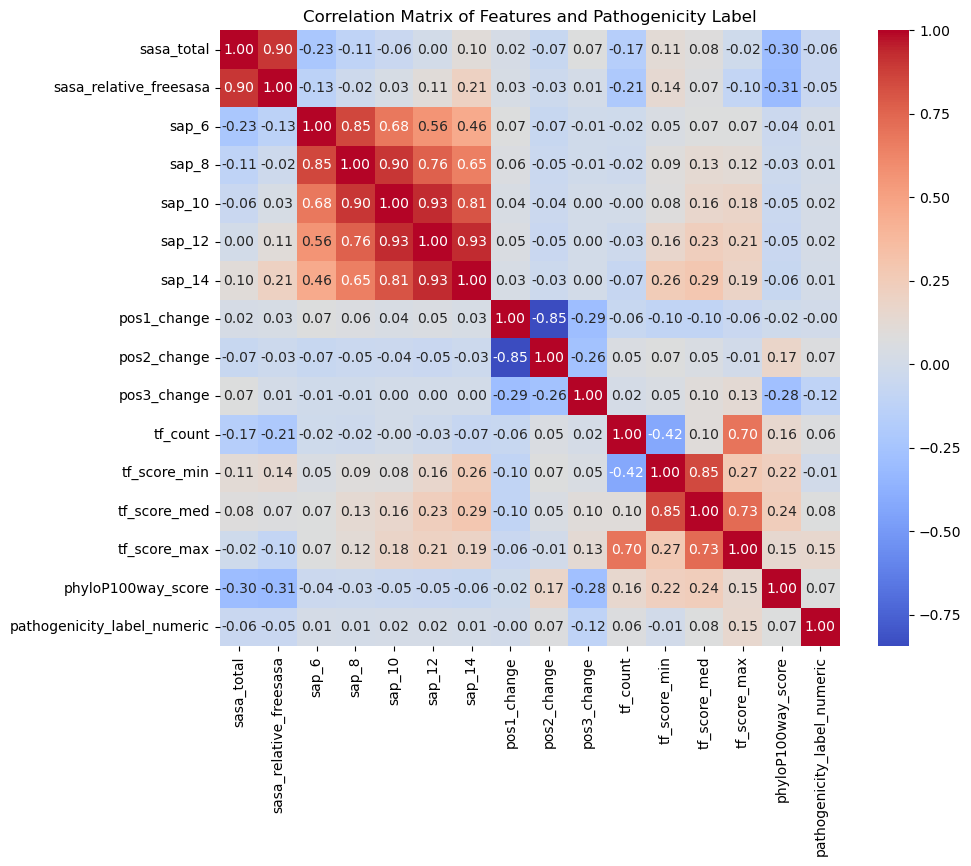

In [788]:
# Select numerical features for correlation. Ensure labels are numeric for correlation.
# Make sure 'pathogenicity_label' is numeric for correlation
df_for_corr = df_features.copy()
if 'pathogenicity_label' in df_for_corr.columns:
    df_for_corr['pathogenicity_label_numeric'] = pd.to_numeric(df_for_corr['pathogenicity_label'], errors='coerce')

numerical_features_for_corr = [
    'sasa_total', 'sasa_relative_freesasa', 'sap_6', 
    'sap_8', 'sap_10', 'sap_12', 'sap_14',
    'pos1_change', 'pos2_change', 'pos3_change',
    'tf_count', 'tf_score_min', 'tf_score_med', 
    'tf_score_max', 'phyloP100way_score'
]
if 'pathogenicity_label_numeric' in df_for_corr.columns:
    numerical_features_for_corr.append('pathogenicity_label_numeric')

# Filter out columns that might not exist or are all NA to avoid errors in .corr()
existing_numerical_features = [col for col in numerical_features_for_corr if col in df_for_corr.columns and df_for_corr[col].notna().any()]

if existing_numerical_features:
    correlation_matrix = df_for_corr[existing_numerical_features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Features and Pathogenicity Label")
    plt.show()
else:
    print("No numerical features available for correlation matrix after filtering NAs.")

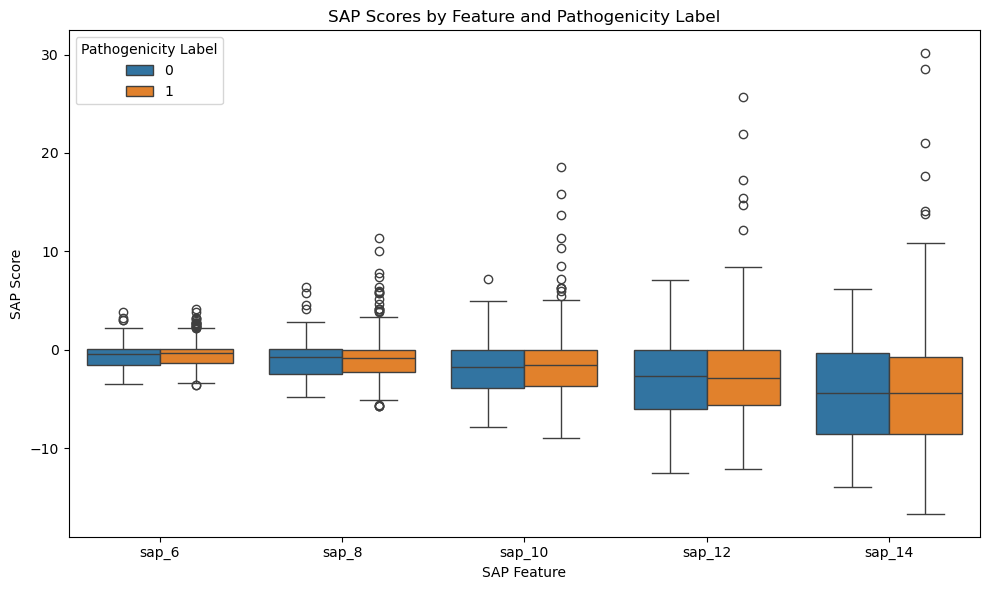

In [789]:
# List of SAP feature columns
sap_cols = ['sap_6', 'sap_8', 'sap_10', 'sap_12', 'sap_14']

# Check necessary conditions
if all(col in df_features.columns for col in sap_cols) and 'pathogenicity_label' in df_features.columns:
    # Melt the DataFrame into long format
    df_melted = df_features.melt(id_vars='pathogenicity_label', value_vars=sap_cols,
                                 var_name='SAP_Feature', value_name='SAP_Score')

    # Drop rows with missing labels or scores
    df_melted = df_melted.dropna(subset=['pathogenicity_label', 'SAP_Score'])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='SAP_Feature', y='SAP_Score', hue='pathogenicity_label', data=df_melted)
    plt.title("SAP Scores by Feature and Pathogenicity Label")
    plt.xlabel("SAP Feature")
    plt.ylabel("SAP Score")
    plt.legend(title="Pathogenicity Label")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: required columns are missing.")


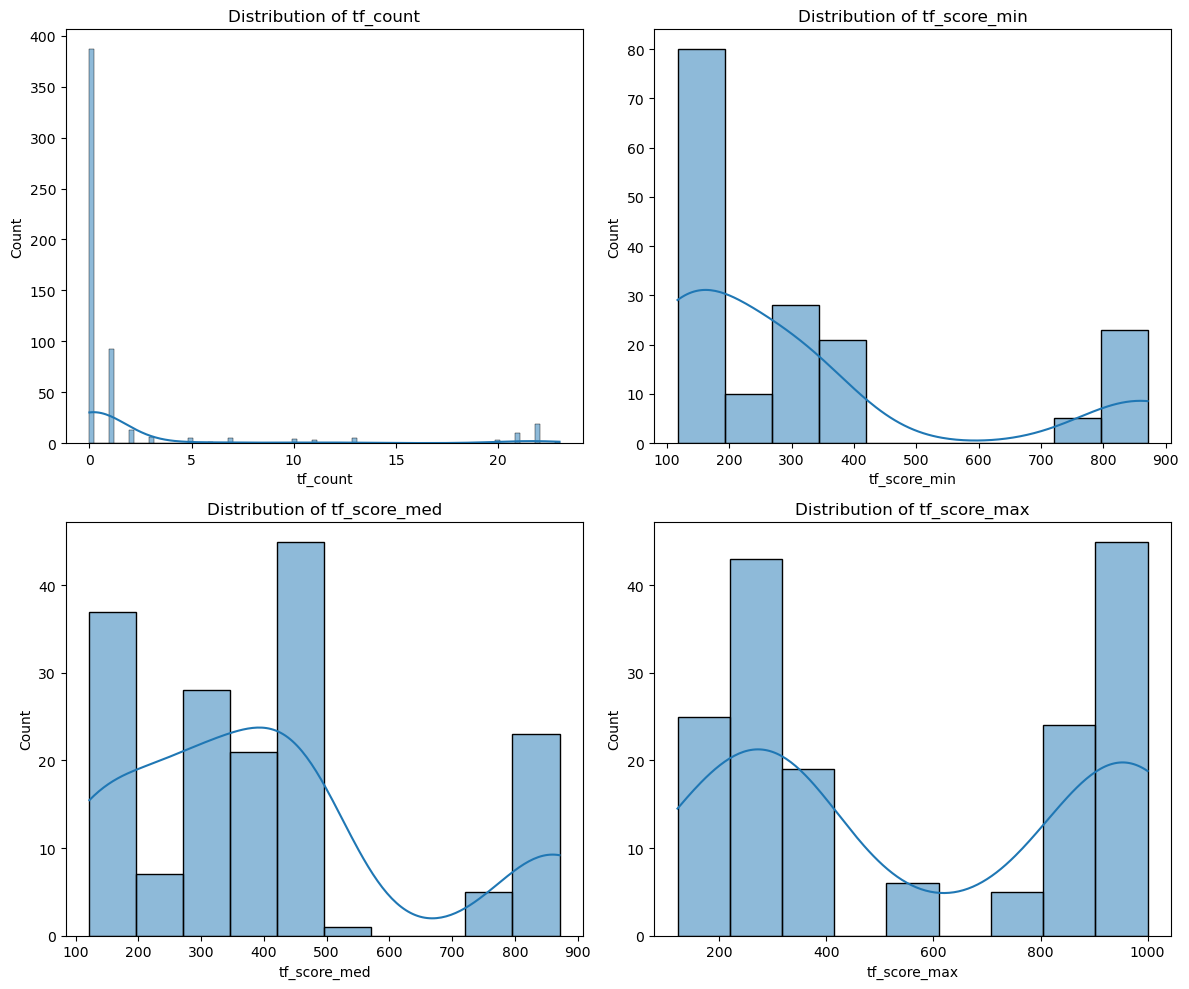

In [790]:
tf_features = ['tf_count', 'tf_score_min', 'tf_score_med', 'tf_score_max']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i, col in enumerate(tf_features):
    if col in df_features.columns:
        sns.histplot(df_features[col].dropna(), ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

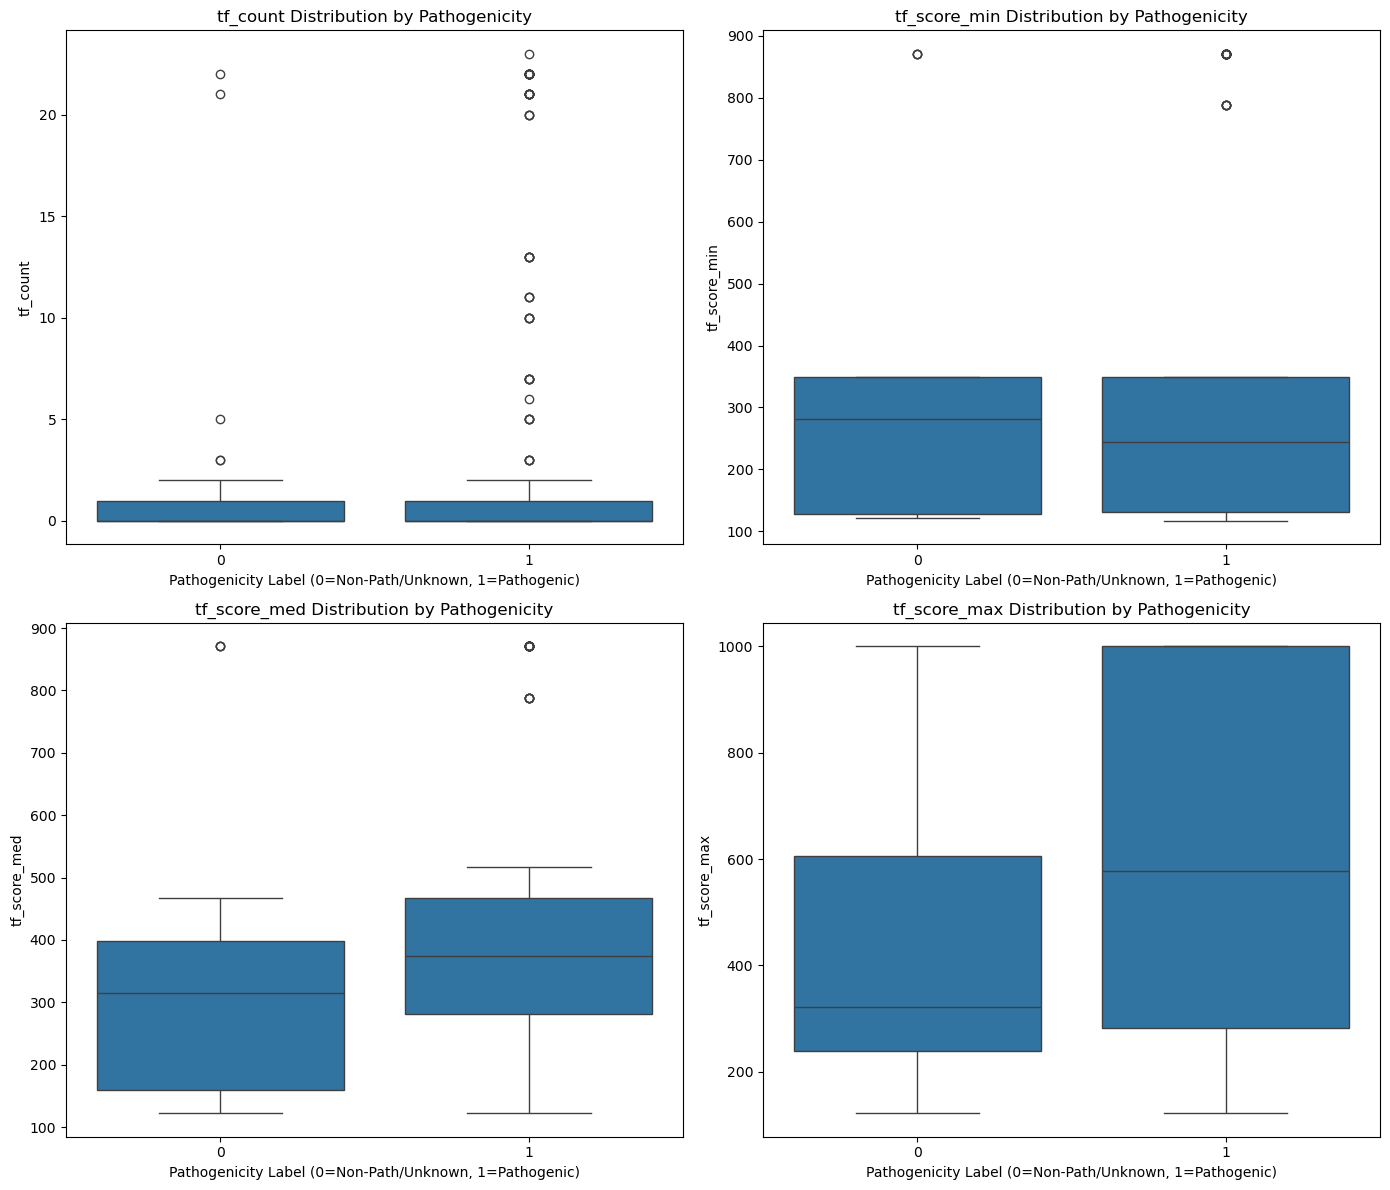

In [791]:
plot_data = df_features.dropna(subset=['pathogenicity_label'])

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(tf_features):
    if col in plot_data.columns:
        sns.boxplot(x='pathogenicity_label', y=col, data=plot_data, ax=axes[i])
        axes[i].set_title(f'{col} Distribution by Pathogenicity')
        axes[i].set_xlabel("Pathogenicity Label (0=Non-Path/Unknown, 1=Pathogenic)")

plt.tight_layout()
plt.show()

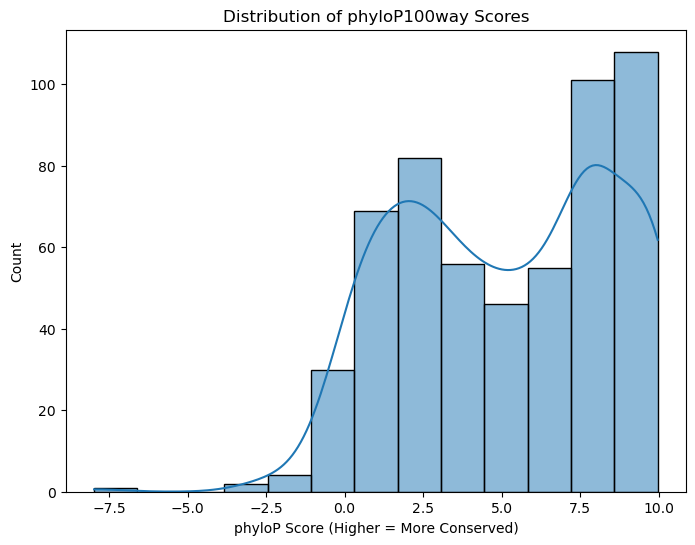

In [792]:
if 'phyloP100way_score' in df_features.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_features['phyloP100way_score'].dropna(), kde=True)
    plt.title('Distribution of phyloP100way Scores')
    plt.xlabel('phyloP Score (Higher = More Conserved)')
    plt.ylabel('Count')
    plt.show()

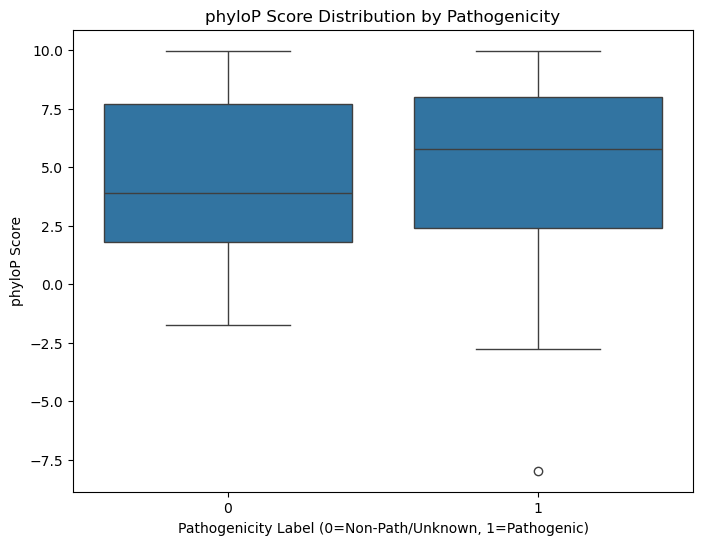

In [793]:
if 'phyloP100way_score' in df_features.columns and 'pathogenicity_label' in df_features.columns:
    plot_data = df_features.dropna(subset=['pathogenicity_label', 'phyloP100way_score'])
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='pathogenicity_label', y='phyloP100way_score', data=plot_data)
    plt.title('phyloP Score Distribution by Pathogenicity')
    plt.xlabel("Pathogenicity Label (0=Non-Path/Unknown, 1=Pathogenic)")
    plt.ylabel("phyloP Score")
    plt.show()

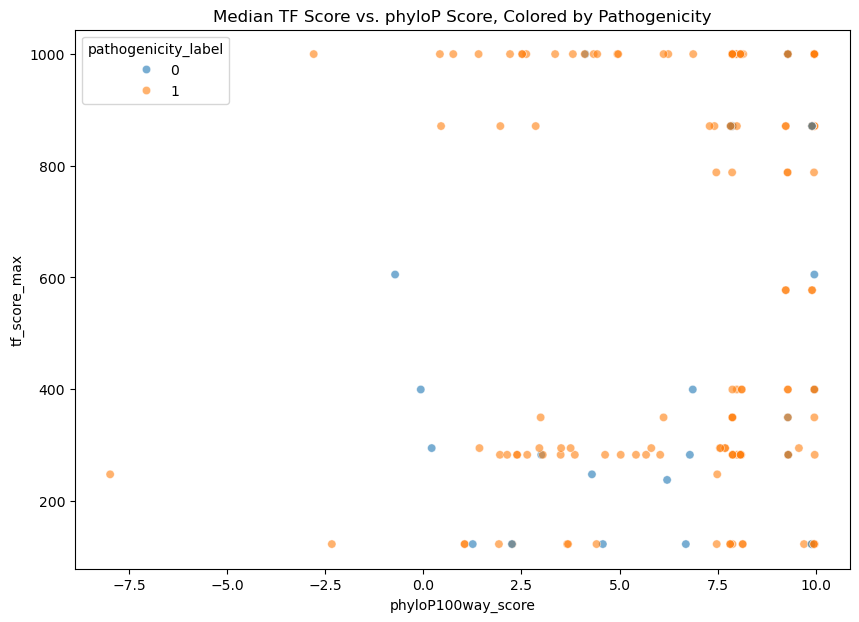

In [794]:
if 'phyloP100way_score' in plot_data.columns and 'tf_score_med' in plot_data.columns:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='phyloP100way_score', y='tf_score_max', hue='pathogenicity_label', data=plot_data, alpha=0.6)
    plt.title('Median TF Score vs. phyloP Score, Colored by Pathogenicity')
    plt.show()

In [795]:
df_missense_for_modeling = df_features[
    df_features['MUTATION_DESCRIPTION'].str.contains('missense_variant', na=False)
].copy()

# Ensure pathogenicity_label is clean (0 or 1, no NAs for modeling)
df_missense_for_modeling = df_missense_for_modeling.dropna(subset=['pathogenicity_label'])
df_missense_for_modeling['pathogenicity_label'] = df_missense_for_modeling['pathogenicity_label'].astype(int)
print(f"\nShape of missense mutations DataFrame for modeling: {df_missense_for_modeling.shape}")
print(f"Label distribution:\n{df_missense_for_modeling['pathogenicity_label'].value_counts()}")


Shape of missense mutations DataFrame for modeling: (554, 479)
Label distribution:
pathogenicity_label
1    481
0    73 
Name: count, dtype: int64


In [796]:
# Basic exploration of codon feature patterns
if 'wt_mut_transition' in df_features.columns and \
   'pathogenicity_label' in df_features.columns and \
   df_features['pathogenicity_label'].notna().any():
    print("\nMost common wt_mut_transitions for Pathogenic (1) mutations:")
    pathogenic_transitions = df_features[df_features['pathogenicity_label'] == 1]['wt_mut_transition'].value_counts().head()
    print(pathogenic_transitions)

    print("\nMost common wt_mut_transitions for Non-Pathogenic/Unknown (0) mutations:")
    non_pathogenic_transitions = df_features[df_features['pathogenicity_label'] == 0]['wt_mut_transition'].value_counts().head()
    print(non_pathogenic_transitions)
else:
    print("\nSkipping codon transition analysis: 'wt_mut_transition' or 'pathogenicity_label' missing or all NA labels.")


Most common wt_mut_transitions for Pathogenic (1) mutations:
wt_mut_transition
GAC>AAC    13
CCC>CTC    12
GTG>ATG    11
GAG>AAG    11
GAA>AAA    11
Name: count, dtype: int64

Most common wt_mut_transitions for Non-Pathogenic/Unknown (0) mutations:
wt_mut_transition
AGC>AGA    2
GAC>AAC    2
TCC>TTC    2
AGG>AGT    2
GTG>ATG    2
Name: count, dtype: int64


In [ ]:
print(df_features.groupby('pathogenicity_label')[['pos1_change', 'pos2_change', 'pos3_change']].sum())

# Get total number of mutations with codon info for each label
# Ensure 'pathogenicity_label' is treated as numeric for value_counts if it contains NA that we want to count
# or if it's object type. Converting to float first can help.
temp_labels = pd.to_numeric(df_features.dropna(subset=['pos1_change'])['pathogenicity_label'], errors='coerce')
label_counts = temp_labels.value_counts()


codon_change_sums = df_features.groupby('pathogenicity_label')[['pos1_change', 'pos2_change', 'pos3_change']].sum()

# Calculate proportions
# Initialize with float dtype or change after copying
codon_change_proportions = codon_change_sums.copy().astype(float)

if 0 in label_counts.index and label_counts.get(0, 0) > 0 :
    codon_change_proportions.loc[0] = codon_change_sums.loc[0] / label_counts[0]
if 1 in label_counts.index and label_counts.get(1, 0) > 0:
    codon_change_proportions.loc[1] = codon_change_sums.loc[1] / label_counts[1]
# Handle cases where a label might not be present in label_counts (e.g. only pathogenic after some filter)
if 0 not in codon_change_proportions.index and 0 in label_counts.index: # if label 0 existed but was removed by groupby
    codon_change_proportions.loc[0] = 0.0 # or np.nan
if 1 not in codon_change_proportions.index and 1 in label_counts.index:
    codon_change_proportions.loc[1] = 0.0 # or np.nan


print("\nProportions of Codon Position Changes by Pathogenicity Label:")
print(codon_change_proportions)

                     pos1_change  pos2_change  pos3_change
pathogenicity_label                                       
0                    35.0         25.0         12.0       
1                    230.0        213.0        34.0       

Proportions of Codon Position Changes by Pathogenicity Label:
                     pos1_change  pos2_change  pos3_change
pathogenicity_label                                       
0                    0.486111     0.347222     0.166667   
1                    0.482180     0.446541     0.071279   


In [798]:
df_features.shape

(554, 479)

In [799]:
from collections import Counter, defaultdict
from itertools import combinations
import re
import random
import numpy as np
import math
from typing import Tuple

from scipy.stats import kendalltau

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state

import shap

from lightgbm import LGBMClassifier, early_stopping

In [800]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [801]:
df_features = pd.read_csv("EGFR_COSMIC_processed_features.csv")

In [802]:
np.random.seed(42)
random.seed(42)

In [803]:
y = df_features['pathogenicity_label'].astype(int)
X = df_features.drop(columns=['pathogenicity_label'])
print(f"Shape of X (features) is: {X.shape}")
print(f"Shape of y (target) is: {y.shape}")

Shape of X (features) is: (554, 478)
Shape of y (target) is: (554,)


In [804]:
X.wt_mut_transition.value_counts()

wt_mut_transition
GAC>AAC    15
GAG>AAG    13
GTG>ATG    13
TCC>TTC    12
CCC>CTC    12
GAA>AAA    11
CGC>TGC    10
GGC>AGC    9 
CGC>CAC    8 
GCC>GTC    8 
GCC>ACC    7 
ACG>ATG    7 
GGC>GAC    7 
TAC>TGC    7 
CCT>TCT    6 
GAT>AAT    6 
TAT>TGT    6 
CGG>TGG    6 
GTC>ATC    6 
CAC>TAC    6 
TGC>TAC    5 
GGG>AGG    5 
CGG>CAG    5 
TGC>TCC    5 
ACC>ATC    5 
GGA>AGA    5 
CGA>CAA    5 
CCC>TCC    5 
AAG>AAT    5 
GGC>TGC    4 
CAG>CAT    4 
ACC>GCC    4 
GGG>GTG    4 
GAC>TAC    4 
GCA>CCA    4 
AGC>AGA    4 
ATG>ATT    4 
CCT>CAT    4 
GCA>GTA    4 
ATC>GTC    4 
CTG>ATG    4 
TCC>TGC    4 
ATA>GTA    4 
CTC>TTC    4 
CGC>CTC    3 
GCT>GTT    3 
GCC>TCC    3 
CTG>GTG    3 
CGC>CCC    3 
CGT>TGT    3 
AAC>AGC    3 
ATC>TTC    3 
GCT>ACT    3 
GAG>CAG    3 
GTG>TTG    3 
AGC>ATC    3 
CCG>CTG    3 
GGA>GAA    3 
CCG>TCG    3 
TGC>TTC    3 
ACA>AAA    3 
GAA>GGA    3 
CAG>CAC    3 
CCA>TCA    3 
ATG>ATA    3 
AAA>GAA    3 
GAA>GCA    3 
GCG>GTG    3 
AGC>AAC    3 
CCA>CTA    3 
GA

In [805]:
X.nucleotide_context.value_counts()

nucleotide_context
CCGCA    6
CCTGG    5
CTGCA    5
GATGG    5
GAAAG    5
CGGCC    5
CCGTG    4
CGACA    4
CCAGA    4
GTGTA    4
TGCCA    4
CTCCA    4
AGACG    4
TCCCA    4
CAGCA    4
CAGCC    4
CCCCC    4
CCCGG    4
CACCT    4
GGAAA    4
TGCCC    4
CCGAG    3
CGGAA    3
TCGCT    3
TCCCG    3
AGGAG    3
CTGCC    3
GGAGA    3
GGTGG    3
TCCAA    3
CCCTC    3
GCTGG    3
ACAGG    3
AACAT    3
CGTGG    3
CAAGG    3
CGCGC    3
GGAGC    3
CCACA    3
GCAGA    3
CGCCG    3
GATCA    3
TGGGA    3
CCCTG    2
GCGCT    2
CTACA    2
GTCCC    2
TGAGG    2
TGCTG    2
AAAGT    2
GAGCT    2
GCGGG    2
CGGGC    2
CGACG    2
CGAAT    2
ATTAA    2
TCCGA    2
TCAGG    2
TCGCC    2
AGACA    2
GCTCA    2
CAAGC    2
AGGCG    2
CGTTC    2
GTCCA    2
CCCGT    2
AGATC    2
GGATG    2
TCCCC    2
TGTGG    2
CCGTA    2
TGCGG    2
AGAGA    2
CTTGG    2
CGGAT    2
ATGCA    2
GCCAG    2
CGTAC    2
CAAGA    2
ACTGC    2
AACAC    2
TGACT    2
CAACC    2
CACGT    2
CCTTG    2
CATAA    2
AACCG    2
TGCAA    2
TGCCT    2
AG

In [806]:
cols_to_drop_manual = ["GENE_SYMBOL","COSMIC_GENE_ID","TRANSCRIPT_ACCESSION","COSMIC_SAMPLE_ID","SAMPLE_NAME","COSMIC_PHENOTYPE_ID","GENOMIC_MUTATION_ID","LEGACY_MUTATION_ID","MUTATION_ID","MUTATION_CDS","MUTATION_AA","MUTATION_DESCRIPTION","MUTATION_ZYGOSITY","LOH","CHROMOSOME","GENOME_START","GENOME_STOP","STRAND","PUBMED_PMID","COSMIC_STUDY_ID","HGVSP","HGVSC","HGVSG","GENOMIC_WT_ALLELE","GENOMIC_MUT_ALLELE","MUTATION_SOMATIC_STATUS","AA","CDS","GENE","GENOME_SCREEN_SAMPLE_COUNT","IS_CANONICAL","LEGACY_ID","OLD_VARIANT","SO_TERM","TF","TF_SCORE","UNIPROT_ID","GENE_NAME", "pos1_change", "pos2_change", "pos3_change", "sap_score"]
X = X.drop(columns=cols_to_drop_manual, axis=1, errors='ignore')

In [807]:
nan_threshold = 0.9
nan_percentages = X.isnull().sum() / len(X)
cols_to_drop_nan = nan_percentages[nan_percentages > nan_threshold].index

In [808]:
cols_to_drop_nan.value_counts()

Series([], Name: count, dtype: int64)

In [809]:
X = X.drop(columns=cols_to_drop_nan)
print(f"Dropped {len(cols_to_drop_nan)} columns with more than {nan_threshold*100}% NaN values.")
print(f"Shape of X is now: {X.shape}")

Dropped 0 columns with more than 90.0% NaN values.
Shape of X is now: (554, 436)


In [ ]:
SEQ_COLS = [c for c in ['nucleotide_context', 'wt_mut_transition'] if c in X.columns]

def _one_hot_base(b):
    # A, C, G, T, else N
    bases = ['A','C','G','T']
    return [1 if b==bb else 0 for bb in bases]

def _is_transition(ref, alt):
    pur = set(['A','G']); pyr = set(['C','T'])
    if ref in pur and alt in pur: return 1
    if ref in pyr and alt in pyr: return 1
    return 0

class SequenceContextEncoder(BaseEstimator, TransformerMixin):
    """Deterministic, leak-free encoder for nucleotide_context (5-mer) and wt_mut_transition (XYZ>ABC)."""
    def __init__(self, nuc_col='nucleotide_context', wtmut_col='wt_mut_transition'):
        self.nuc_col = nuc_col
        self.wtmut_col = wtmut_col
        self.out_columns_ = None

    def fit(self, X, y=None):
        # define output column names deterministically
        cols = []
        if self.nuc_col in X.columns:
            # 5 positions x 4 bases
            for i in range(5):
                for b in ['A','C','G','T']:
                    cols.append(f"{self.nuc_col}_pos{i+1}_{b}")
            cols += [f"{self.nuc_col}_GC_count", f"{self.nuc_col}_has_CpG"]
        if self.wtmut_col in X.columns:
            # changed position 1..3
            cols += [f"{self.wtmut_col}_chgpos_{i}" for i in [1,2,3]]
            # substitution type collapsed to 6 (pyrimidine-oriented)
            for sub in ["C>A","C>G","C>T","T>A","T>C","T>G"]:
                cols.append(f"{self.wtmut_col}_sub_{sub}")
            cols.append(f"{self.wtmut_col}_is_transition")
            # central ref base one-hot
            for b in ['A','C','G','T']:
                cols.append(f"{self.wtmut_col}_center_ref_{b}")
            # CpG presence before/after (in 3-mer scope)
            cols += [f"{self.wtmut_col}_has_CpG_before", f"{self.wtmut_col}_has_CpG_after"]
            # multi-position change flag
            cols.append(f"{self.wtmut_col}_multi_change")
        self.out_columns_ = cols
        return self
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.out_columns_, dtype=object)

    def transform(self, X):
        out = []
        n = len(X)
        # init zeros
        Z = np.zeros((n, len(self.out_columns_)), dtype=float)
        col_idx = {c:i for i,c in enumerate(self.out_columns_)}
        # nucleotide_context
        if self.nuc_col in X.columns:
            nuc_vals = X[self.nuc_col].astype(str).fillna("")
            for i, s in enumerate(nuc_vals):
                s = s.upper()
                if len(s) != 5:
                    # pad/truncate
                    s = (s+"NNNNN")[:5]
                # position one-hots
                for pos in range(5):
                    b = s[pos] if s[pos] in ['A','C','G','T'] else 'N'
                    if b in ['A','C','G','T']:
                        Z[i, col_idx[f"{self.nuc_col}_pos{pos+1}_{b}"]] = 1
                # GC count
                gc = sum(1 for ch in s if ch in ['G','C'])
                Z[i, col_idx[f"{self.nuc_col}_GC_count"]] = gc
                # CpG presence (within the 5-mer)
                Z[i, col_idx[f"{self.nuc_col}_has_CpG"]] = 1 if 'CG' in s else 0

        # wt_mut_transition
        if self.wtmut_col in X.columns:
            wt_vals = X[self.wtmut_col].astype(str).fillna("")
            for i, t in enumerate(wt_vals):
                t = t.upper()
                if '>' not in t:
                    continue
                left, right = t.split('>', 1)
                left = (left+"NNN")[:3]; right = (right+"NNN")[:3]
                # changed position flags
                diffs = [int(left[p]!=right[p]) for p in range(3) if left[p] in 'ACGT' and right[p] in 'ACGT']
                multi_change = 1 if sum(diffs) != 1 else 0
                if not multi_change:
                    chgpos = [p for p in range(3) if left[p] != right[p]][0]
                    Z[i, col_idx[f"{self.wtmut_col}_chgpos_{chgpos+1}"]] = 1
                    ref = left[chgpos]; alt = right[chgpos]
                    # central ref one-hot (center = position 2)
                    if left[1] in ['A','C','G','T']:
                        Z[i, col_idx[f"{self.wtmut_col}_center_ref_{left[1]}"]] = 1
                    # transition vs transversion
                    Z[i, col_idx[f"{self.wtmut_col}_is_transition"]] = _is_transition(ref, alt)
                    # pyrimidine-oriented 6-class: map complements to C or T ref
                    # normalize to pyrimidine ref
                    comp = {'A':'T','C':'G','G':'C','T':'A'}
                    r = ref; a = alt
                    if r in ['A','G']:  # purine -> take complement
                        r = comp[r]; a = comp[a]
                    key = f"{r}>{a}"
                    if key in ["C>A","C>G","C>T","T>A","T>C","T>G"]:
                        Z[i, col_idx[f"{self.wtmut_col}_sub_{key}"]] = 1
                else:
                    Z[i, col_idx[f"{self.wtmut_col}_multi_change"]] = 1
                # CpG before/after within 3-mer proxy
                Z[i, col_idx[f"{self.wtmut_col}_has_CpG_before"]] = 1 if 'CG' in left else 0
                Z[i, col_idx[f"{self.wtmut_col}_has_CpG_after"]]  = 1 if 'CG' in right else 0

        return pd.DataFrame(Z, index=X.index, columns=self.out_columns_)

In [ ]:
enc = SequenceContextEncoder(
    nuc_col="nucleotide_context",
    wtmut_col="wt_mut_transition"
)

seq_features = enc.fit_transform(X)
print(seq_features.shape)
print(enc.get_feature_names_out())

X_encoded = pd.concat([X.reset_index(drop=True), seq_features.reset_index(drop=True)], axis=1)

(554, 39)
['nucleotide_context_pos1_A' 'nucleotide_context_pos1_C'
 'nucleotide_context_pos1_G' 'nucleotide_context_pos1_T'
 'nucleotide_context_pos2_A' 'nucleotide_context_pos2_C'
 'nucleotide_context_pos2_G' 'nucleotide_context_pos2_T'
 'nucleotide_context_pos3_A' 'nucleotide_context_pos3_C'
 'nucleotide_context_pos3_G' 'nucleotide_context_pos3_T'
 'nucleotide_context_pos4_A' 'nucleotide_context_pos4_C'
 'nucleotide_context_pos4_G' 'nucleotide_context_pos4_T'
 'nucleotide_context_pos5_A' 'nucleotide_context_pos5_C'
 'nucleotide_context_pos5_G' 'nucleotide_context_pos5_T'
 'nucleotide_context_GC_count' 'nucleotide_context_has_CpG'
 'wt_mut_transition_chgpos_1' 'wt_mut_transition_chgpos_2'
 'wt_mut_transition_chgpos_3' 'wt_mut_transition_sub_C>A'
 'wt_mut_transition_sub_C>G' 'wt_mut_transition_sub_C>T'
 'wt_mut_transition_sub_T>A' 'wt_mut_transition_sub_T>C'
 'wt_mut_transition_sub_T>G' 'wt_mut_transition_is_transition'
 'wt_mut_transition_center_ref_A' 'wt_mut_transition_center_ref_C'

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)  
pd.set_option('display.max_colwidth', 0)


In [636]:
tf_zero_cols = [c for c in ['tf_count','tf_score_min','tf_score_med','tf_score_max'] if c in X.columns]
num_other     = [c for c in X.select_dtypes(include=np.number).columns if c not in tf_zero_cols]
seq_cols      = [c for c in ['nucleotide_context','wt_mut_transition'] if c in X.columns]

In [ ]:
n_rows = len(X)

# Per-feature missingness
nan_count = X.isna().sum().rename("n_nan")
nan_pct   = (X.isna().mean() * 100).rename("pct_nan")
dtypes    = X.dtypes.rename("dtype")

nan_table = (
    pd.concat([nan_count, nan_pct, dtypes], axis=1)
      .query("n_nan > 0")                      # keep only columns that have NaNs
      .sort_values("pct_nan", ascending=False)
)

print(f"Rows: {n_rows}")
print(f"Rows with any NaN: {X.isna().any(axis=1).mean()*100:.2f}%")


Rows: 554
Rows with any NaN: 88.27%
                            n_nan    pct_nan    dtype
tf_score_med                  387  69.855596  float64
tf_score_max                  387  69.855596  float64
tf_score_min                  387  69.855596  float64
esm2_delta                    100  18.050542  float64
protein_seq                   100  18.050542   object
...                           ...        ...      ...
propy__PolarityD1025           60  10.830325  float64
propy__NormalizedVDWVD3100     60  10.830325  float64
wt_codon                        5   0.902527   object
mut_codon                       5   0.902527   object
wt_mut_transition               5   0.902527   object

[416 rows x 3 columns]


In [637]:
num_other_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
tf_zero_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

transformers = [
    ('num_other', num_other_pipe, num_other),
    ('tf_zero',  tf_zero_pipe,   tf_zero_cols),
]
if seq_cols:
    transformers.append(('seqenc', SequenceContextEncoder(
        nuc_col='nucleotide_context', wtmut_col='wt_mut_transition'
    ), seq_cols))

pre = ColumnTransformer(transformers=transformers, remainder='drop')

# final pipeline: CT -> global scaler
pp = Pipeline([
    ('ct', pre),
    ('scaler', StandardScaler())
])

X_processed = pp.fit_transform(X, y)

# build the column names IN THE SAME ORDER as the CT output
proc_cols = []
proc_cols += num_other
proc_cols += tf_zero_cols
if seq_cols:
    proc_cols += pp.named_steps['ct'].named_transformers_['seqenc'].out_columns_

X_proc_df = pd.DataFrame(X_processed, columns=proc_cols, index=X.index)
print(X_proc_df.isna().sum().sum())  # should be 0

0


In [712]:
X_proc_df.shape

(554, 468)

In [715]:
n_rows = len(X_proc_df)

# Per-feature missingness
nan_count = X_proc_df.isna().sum().rename("n_nan")
nan_pct   = (X_proc_df.isna().mean() * 100).rename("pct_nan")
dtypes    = X_proc_df.dtypes.rename("dtype")

nan_table = (
    pd.concat([nan_count, nan_pct, dtypes], axis=1)
      .query("n_nan > 0")                      # keep only columns that have NaNs
      .sort_values("pct_nan", ascending=False)
)

print(f"Rows: {n_rows}")
print(f"Rows with any NaN: {X_proc_df.isna().any(axis=1).mean()*100:.2f}%")

Rows: 554
Rows with any NaN: 0.00%


In [ ]:
def make_preprocessor(X):
    tf_zero_cols = [c for c in ['tf_count','tf_score_min','tf_score_med','tf_score_max'] if c in X.columns]
    num_other    = [c for c in X.select_dtypes(include=np.number).columns if c not in tf_zero_cols]
    seq_cols     = [c for c in ['nucleotide_context','wt_mut_transition'] if c in X.columns]

    num_other_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
    tf_zero_pipe   = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0))])

    transformers = [
        ('num_other', num_other_pipe, num_other),
        ('tf_zero',  tf_zero_pipe,   tf_zero_cols),
    ]
    if seq_cols:
        transformers.append(('seqenc', SequenceContextEncoder(
            nuc_col='nucleotide_context', wtmut_col='wt_mut_transition'
        ), seq_cols))

    ct = ColumnTransformer(transformers=transformers, remainder='drop', verbose_feature_names_out=False)
    pp = Pipeline([('ct', ct), ('scaler', StandardScaler())])
    pp.set_output(transform="pandas")
    return pp

In [639]:
def create_feature_bags(df_columns):
    """
    Groups feature names into bags with regex and manual rules.
    
    This is designed to handle complex names like 'propy_MoreauBrotoAuto_Steric1'
    by identifying 'propy_MoreauBrotoAuto_Steric' as the base name.
    """
    bags = defaultdict(list)
    
    # This regex captures a base name that is followed by a number at the very end.
    pattern = re.compile(r'^(.*\D)(\d+)$')

    # These are one-hot encoded groups and should remain as individual features.
    one_hot_prefixes_to_ignore = {
        'wt_mut_transition_chgpos'
    }

    # Manual groups for features that the regex might miss
    manual_groups = {
        'tf_score': ['tf_score_min', 'tf_score_med', 'tf_score_max'],
        'propy_AAComp': [
            'propy_A', 'propy_R', 'propy_N', 'propy_D', 'propy_C', 'propy_E', 'propy_Q',
            'propy_G', 'propy_H', 'propy_I', 'propy_L', 'propy_K', 'propy_M', 'propy_F',
            'propy_P', 'propy_S', 'propy_T', 'propy_W', 'propy_Y', 'propy_V'
        ]
    }
    manually_grouped_flat = {col for group in manual_groups.values() for col in group}

    for col in df_columns:
        # Skip manually grouped columns for now
        if col in manually_grouped_flat:
            continue

        # Check if the column belongs to a group we should ignore
        is_ignored_one_hot = False
        for prefix in one_hot_prefixes_to_ignore:
            if col.startswith(prefix):
                # Treat it as a singleton by making its bag name unique
                bags[col].append(col)
                is_ignored_one_hot = True
                break
        if is_ignored_one_hot:
            continue
            
        # Apply the standard regex for all other features
        match = pattern.match(col)
        if match:
            base_name = match.group(1).rstrip('_')
            bags[base_name].append(col)
        else:
            bags[col].append(col)

    # Add the manual groups back in as complete bags
    for group_name, cols in manual_groups.items():
        # Ensure all columns exist in the original df_columns before adding
        existing_cols = [c for c in cols if c in df_columns]
        if existing_cols:
            bags[group_name].extend(existing_cols)

    print(f"Identified {len(bags)} feature bags after refinement.")
    return bags

In [640]:
feature_bags = create_feature_bags(X_proc_df)

Identified 83 feature bags after refinement.


In [641]:
def select_bag_representatives_pls(Xdf, y, bags, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    chosen = {}
    for bag, cols in bags.items():
        if len(cols) == 1:
            chosen[bag] = cols[0]
            continue
        wins = Counter()
        for train_idx, test_idx in skf.split(Xdf, y):
            Xtr = Xdf.iloc[train_idx][cols]
            ytr = y.iloc[train_idx]
            # guard against degenerate variance
            if Xtr.shape[1] < 2 or np.all(Xtr.var(axis=0).values == 0):
                wins[cols[0]] += 1
                continue
            pls = PLSRegression(n_components=1)
            pls.fit(Xtr.values, ytr.values)
            # x_weights_: (n_features, n_components)
            load = np.abs(pls.x_weights_[:,0])
            winner = cols[int(np.argmax(load))]
            wins[winner] += 1
        # pick feature that won most folds
        chosen[bag] = wins.most_common(1)[0][0]
    return chosen

In [642]:
bag_reps = select_bag_representatives_pls(X_proc_df, y, feature_bags, n_splits=5)
rep_cols = [bag_reps[b] for b in bag_reps.keys()]
df_reps_pls = X_proc_df[rep_cols].copy()
print(f"PLS-selected representatives: {df_reps_pls.shape[1]} features.")

PLS-selected representatives: 83 features.


In [716]:
rep_cols

['gerp_nr',
 'gerp_rs',
 'esm2_delta',
 'phyloP100way_score',
 'phastCons100way_score',
 'propy__PolarizabilityC2',
 'propy__SolventAccessibilityC3',
 'propy__SecondaryStrC1',
 'propy__ChargeC2',
 'propy__PolarityC2',
 'propy__NormalizedVDWVC2',
 'propy__HydrophobicityC3',
 'propy__PolarizabilityT13',
 'propy__SolventAccessibilityT13',
 'propy__SecondaryStrT13',
 'propy__ChargeT13',
 'propy__PolarityT13',
 'propy__NormalizedVDWVT23',
 'propy__HydrophobicityT13',
 'propy__PolarizabilityD2075',
 'propy__SolventAccessibilityD3050',
 'propy__SecondaryStrD3050',
 'propy__ChargeD3075',
 'propy__PolarityD2025',
 'propy__NormalizedVDWVD2100',
 'propy__HydrophobicityD2025',
 'propy_MoreauBrotoAuto_Hydrophobicity15',
 'propy_MoreauBrotoAuto_AvFlexibility4',
 'propy_MoreauBrotoAuto_Polarizability5',
 'propy_MoreauBrotoAuto_FreeEnergy12',
 'propy_MoreauBrotoAuto_ResidueASA12',
 'propy_MoreauBrotoAuto_ResidueVol29',
 'propy_MoreauBrotoAuto_Steric29',
 'propy_MoreauBrotoAuto_Mutability26',
 'blosum8

In [643]:
df_reps_pls.head()

gerp_nr   gerp_rs  esm2_delta  phyloP100way_score  phastCons100way_score  \
0 -4.381013 -0.005180    0.379424           -0.759769              -0.236125   
1 -5.957479 -0.848218    0.035392           -1.410221              -2.617134   
2 -4.252322 -3.871773    0.035392           -2.360336              -2.651193   
3 -4.252322 -0.314650   -0.213146           -0.882117               0.445048   
4 -4.252322 -0.702376   -0.206801           -1.118833               0.324295   

   propy__PolarizabilityC2  propy__SolventAccessibilityC3  \
0                -0.176259                       0.325060   
1                -0.176259                      -3.471166   
2                -0.176259                      -3.471166   
3                -0.754053                      -0.623996   
4                -0.754053                      -0.623996   

   propy__SecondaryStrC1  propy__ChargeC2  propy__PolarityC2  ...  \
0               0.101920        -0.149491           0.034751  ...   
1              -0.934109         0.612636          -3.547057  ...   
2              -0.934109         0.612636          -3.547057  ...   
3               1.914970        -1.165659           1.377930  ...   
4               1.914970        -1.165659           1.377930  ...   

   wt_mut_transition_is_transition  wt_mut_transition_center_ref_A  \
0                         0.817725                       -0.592638   
1                         0.817725                       -0.592638   
2                         0.817725                       -0.592638   
3                         0.817725                        1.687371   
4                        -1.222905                        1.687371   

   wt_mut_transition_center_ref_C  wt_mut_transition_center_ref_G  \
0                       -0.612119                        1.641138   
1                        1.633669                       -0.609333   
2                       -0.612119                        1.641138   
3                       -0.612119                       -0.609333   
4                       -0.612119                       -0.609333   

   wt_mut_transition_center_ref_T  wt_mut_transition_has_CpG_before  \
0                        -0.48074                          2.608221   
1                        -0.48074                         -0.383403   
2                        -0.48074                          2.608221   
3                        -0.48074                         -0.383403   
4                        -0.48074                         -0.383403   

   wt_mut_transition_has_CpG_after  wt_mut_transition_multi_change  \
0                        -0.239274                             0.0   
1                        -0.239274                             0.0   
2                        -0.239274                             0.0   
3                        -0.239274                             0.0   
4                        -0.239274                             0.0   

   tf_score_max   propy_M  
0       2.54884  0.138735  
1       2.54884  2.085807  
2       2.54884  2.085807  
3       2.54884  0.662947  
4       2.54884  0.662947  

[5 rows x 83 columns]

In [644]:
def engineer_bag_features(df, bags, std_eligible_prefixes=('sap',)):
    feats = []
    names = []
    for bag, cols in bags.items():
        cols = [c for c in cols if c in df.columns]
        if len(cols) == 0:
            continue
        if len(cols) == 1:
            feats.append(df[cols[0]].values.reshape(-1,1))
            names.append(cols[0])
            continue
        med = df[cols].median(axis=1).values.reshape(-1,1)
        feats.append(med); names.append(f"{bag}_median")
        if any(bag.startswith(x) for x in std_eligible_prefixes):
            stdv = df[cols].std(axis=1).fillna(0).values.reshape(-1,1)
            feats.append(stdv); names.append(f"{bag}_std")
    if len(feats)==0:
        return pd.DataFrame(index=df.index)
    M = np.hstack(feats)
    return pd.DataFrame(M, columns=names, index=df.index)

In [645]:
df_aggregated = engineer_bag_features(X_proc_df, feature_bags)
print(f"Aggregated (median/std) features: {df_aggregated.shape}")

Aggregated (median/std) features: (554, 84)


In [646]:
df_aggregated.head()

gerp_nr   gerp_rs  esm2_delta  phyloP100way_score  phastCons100way_score  \
0 -4.381013 -0.005180    0.379424           -0.759769              -0.236125   
1 -5.957479 -0.848218    0.035392           -1.410221              -2.617134   
2 -4.252322 -3.871773    0.035392           -2.360336              -2.651193   
3 -4.252322 -0.314650   -0.213146           -0.882117               0.445048   
4 -4.252322 -0.702376   -0.206801           -1.118833               0.324295   

   propy__PolarizabilityC_median  propy__SolventAccessibilityC_median  \
0                      -0.176259                             0.145679   
1                      -0.176259                             1.394875   
2                      -0.176259                             1.394875   
3                      -0.754053                            -0.623996   
4                      -0.754053                            -0.623996   

   propy__SecondaryStrC_median  propy__ChargeC_median  \
0                     0.101920               0.003199   
1                    -0.140956               0.612636   
2                    -0.140956               0.612636   
3                     1.070347               0.635684   
4                     1.070347               0.635684   

   propy__PolarityC_median  ...  wt_mut_transition_is_transition  \
0                 0.034751  ...                         0.817725   
1                 0.936917  ...                         0.817725   
2                 0.936917  ...                         0.817725   
3                 1.377930  ...                         0.817725   
4                 1.377930  ...                        -1.222905   

   wt_mut_transition_center_ref_A  wt_mut_transition_center_ref_C  \
0                       -0.592638                       -0.612119   
1                       -0.592638                        1.633669   
2                       -0.592638                       -0.612119   
3                        1.687371                       -0.612119   
4                        1.687371                       -0.612119   

   wt_mut_transition_center_ref_G  wt_mut_transition_center_ref_T  \
0                        1.641138                        -0.48074   
1                       -0.609333                        -0.48074   
2                        1.641138                        -0.48074   
3                       -0.609333                        -0.48074   
4                       -0.609333                        -0.48074   

   wt_mut_transition_has_CpG_before  wt_mut_transition_has_CpG_after  \
0                          2.608221                        -0.239274   
1                         -0.383403                        -0.239274   
2                          2.608221                        -0.239274   
3                         -0.383403                        -0.239274   
4                         -0.383403                        -0.239274   

   wt_mut_transition_multi_change  tf_score_median  propy_AAComp_median  
0                             0.0         1.430999             0.098862  
1                             0.0         1.430999             0.289837  
2                             0.0         1.430999             0.289837  
3                             0.0         1.430999             0.193443  
4                             0.0         1.430999             0.193443  

[5 rows x 84 columns]

In [647]:
feature_bags

defaultdict(list,
            {'gerp_nr': ['gerp_nr'],
             'gerp_rs': ['gerp_rs'],
             'esm2_delta': ['esm2_delta'],
             'phyloP100way_score': ['phyloP100way_score'],
             'phastCons100way_score': ['phastCons100way_score'],
             'propy__PolarizabilityC': ['propy__PolarizabilityC1',
              'propy__PolarizabilityC2',
              'propy__PolarizabilityC3'],
             'propy__SolventAccessibilityC': ['propy__SolventAccessibilityC1',
              'propy__SolventAccessibilityC2',
              'propy__SolventAccessibilityC3'],
             'propy__SecondaryStrC': ['propy__SecondaryStrC1',
              'propy__SecondaryStrC2',
              'propy__SecondaryStrC3'],
             'propy__ChargeC': ['propy__ChargeC1',
              'propy__ChargeC2',
              'propy__ChargeC3'],
             'propy__PolarityC': ['propy__PolarityC1',
              'propy__PolarityC2',
              'propy__PolarityC3'],
             'propy__Normalized


--- Correlation Matrix for Codon Change Position Features ---
                            wt_mut_transition_chgpos_1  \
wt_mut_transition_chgpos_1                    1.000000   
wt_mut_transition_chgpos_2                   -0.831034   
wt_mut_transition_chgpos_3                   -0.288152   

                            wt_mut_transition_chgpos_2  \
wt_mut_transition_chgpos_1                   -0.831034   
wt_mut_transition_chgpos_2                    1.000000   
wt_mut_transition_chgpos_3                   -0.261151   

                            wt_mut_transition_chgpos_3  
wt_mut_transition_chgpos_1                   -0.288152  
wt_mut_transition_chgpos_2                   -0.261151  
wt_mut_transition_chgpos_3                    1.000000  


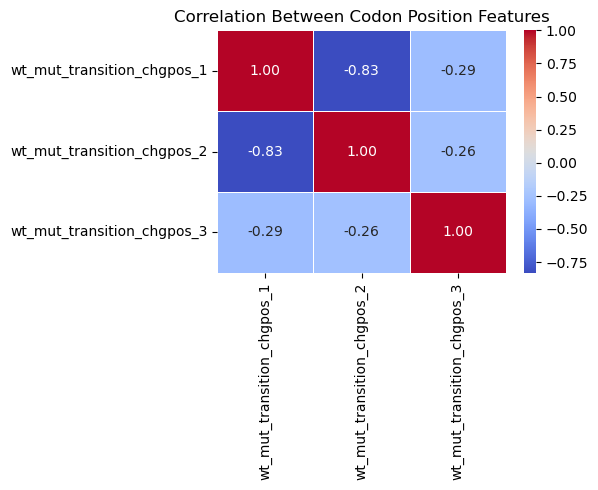

In [ ]:
# Ensure the columns exist in the processed DataFrame
chgpos_features = [
    'wt_mut_transition_chgpos_1',
    'wt_mut_transition_chgpos_2',
    'wt_mut_transition_chgpos_3',
]
chgpos_features_exist = [f for f in chgpos_features if f in X_proc_df.columns]

if len(chgpos_features_exist) == 3:
    # Calculate the correlation matrix for this specific group
    chgpos_corr_matrix = X_proc_df[chgpos_features_exist].corr()
    
    print("\n--- Correlation Matrix for Codon Change Position Features ---")
    print(chgpos_corr_matrix)
    
    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        chgpos_corr_matrix, 
        annot=True,          # Show the correlation values
        cmap='coolwarm',     # Use a diverging colormap
        fmt=".2f",           # Format to 2 decimal places
        linewidths=.5
    )
    plt.title("Correlation Between Codon Position Features")
    plt.tight_layout()
    plt.show()
else:
    print("Could not find all three 'chgpos' features to create a correlation matrix.")

In [649]:
rng = np.random.default_rng(42)
rand_rep_cols = [rng.choice(cols) for cols in feature_bags.values()]
df_random_reps = X_proc_df[rand_rep_cols].copy()

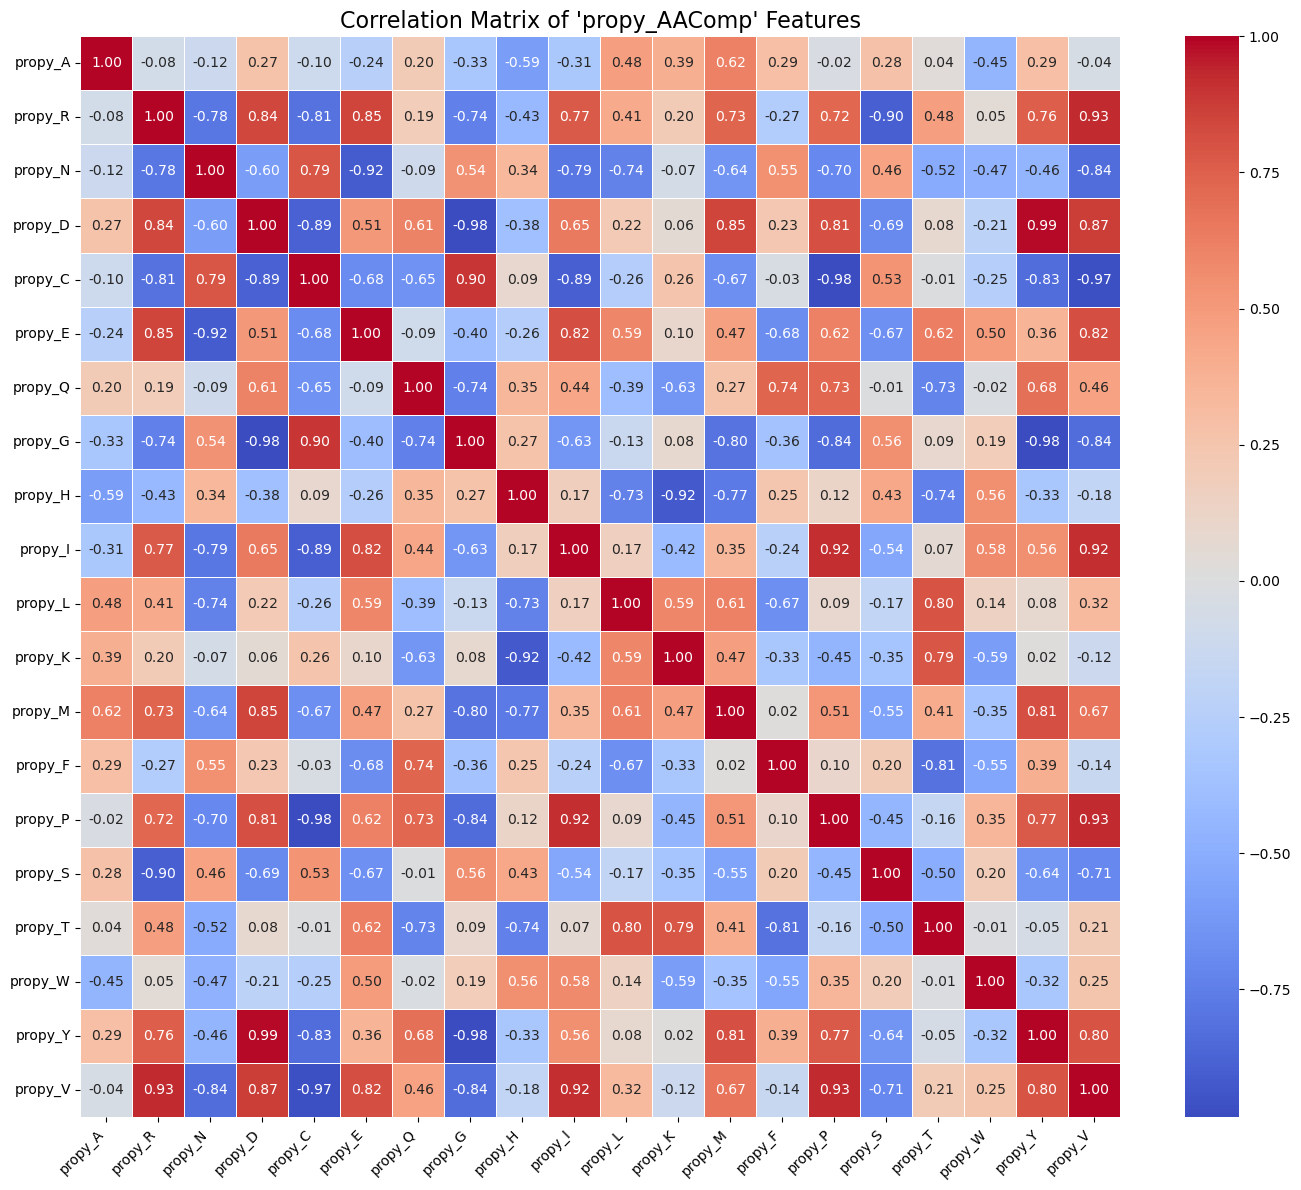

In [650]:
# Get the propy_AAComp features from the feature bags
aa_comp_features = feature_bags['propy_AAComp']

# Filter the DataFrame to include only those features
df_subset = X_proc_df[aa_comp_features]

# Compute the correlation matrix
corr_matrix = df_subset.corr()

# Plot
plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)

plt.title("Correlation Matrix of 'propy_AAComp' Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Extremly randomized trees

In [651]:
def wilson_lower_one_sided(p_hat: float, n: int, alpha: float = 0.05) -> float:
    """One-sided lower (1-alpha) Wilson bound for a Bernoulli mean."""
    if n <= 0:
        return 0.0
    try:
        from scipy.stats import norm
        z = float(norm.ppf(1 - alpha))
    except Exception:
        # Fallback z for common alpha
        z = 1.6448536269514722 if abs(alpha - 0.05) < 1e-9 else 1.2815515655446004  # 0.10
    z2 = z * z
    denom = 1.0 + z2 / n
    center = (p_hat + z2 / (2.0 * n)) / denom
    radius = (z / denom) * math.sqrt(p_hat * (1.0 - p_hat) / n + z2 / (4.0 * n * n))
    lo = max(0.0, center - radius)
    return lo

In [ ]:
def extra_trees_importance_stats(
    Xd, yd, n_estimators=800, max_depth=None, random_state=42,
    # significance controls (new, with safe defaults)
    sig_enable=True, top_k=15, n_repeats=200, row_subsample=0.6, col_subsample=0.6,
    alpha=0.05, min_samples_keep=50
):
    """
    As before, returns (model, imp_df) where imp_df now also has stability columns:
      sample_count, top_count, p_hat, lcb, chance, keep
    """
    et = ExtraTreesClassifier(
        n_estimators=n_estimators, max_depth=max_depth,
        n_jobs=-1, random_state=random_state, class_weight='balanced'
    )
    et.fit(Xd.values, yd.values)

    # per-tree mean±std (unchanged)
    tree_imps = np.vstack([t.feature_importances_ for t in et.estimators_])
    mean_imp = tree_imps.mean(axis=0)
    std_imp  = tree_imps.std(axis=0)
    imp = pd.DataFrame({
        'feature': Xd.columns,
        'mean_importance': mean_imp,
        'std_importance': std_imp
    })

    # stability via resampled top-k wins with Wilson LCB
    if sig_enable:
        rng = np.random.RandomState(random_state + 4242)
        n, d = Xd.shape
        m_rows = max(2, int(round(row_subsample * n)))
        m_cols = max(1, int(round(col_subsample * d)))
        chance = top_k / float(m_cols)

        from collections import Counter
        sample_count = Counter()
        top_count    = Counter()

        for r in range(n_repeats):
            rows = rng.choice(n, size=m_rows, replace=False)
            cols = (Xd.columns if m_cols >= d
                    else Xd.columns[rng.choice(d, size=m_cols, replace=False)])
            Xb = Xd.iloc[rows][list(cols)]
            yb = yd.iloc[rows]

            mdl = ExtraTreesClassifier(
                n_estimators=max(300, n_estimators//2), max_depth=max_depth,
                n_jobs=-1, random_state=int(rng.randint(0, 1e9)),
                class_weight='balanced'
            )
            mdl.fit(Xb.values, yb.values)
            imp_vec = mdl.feature_importances_

            for f in cols:
                sample_count[f] += 1

            k = min(top_k, len(imp_vec))
            winners = pd.Series(imp_vec, index=cols).nlargest(k).index
            for w in winners:
                top_count[w] += 1

        s = pd.Series(sample_count, name='sample_count').reindex(Xd.columns).fillna(0).astype(int)
        t = pd.Series(top_count,    name='top_count').reindex(Xd.columns).fillna(0).astype(int)
        p_hat = (t / s.replace(0, np.nan)).fillna(0.0)
        lcb   = p_hat.copy()
        for f in p_hat.index:
            lcb.loc[f] = wilson_lower_one_sided(float(p_hat.loc[f]), int(s.loc[f]), alpha=alpha)

        imp['sample_count'] = s.values
        imp['top_count']    = t.values
        imp['p_hat']        = p_hat.values
        imp['lcb']          = lcb.values
        imp['chance']       = chance
        imp['keep']         = (imp['lcb'] > imp['chance']) & (imp['sample_count'] >= min_samples_keep)

    imp = imp.sort_values('mean_importance', ascending=False).reset_index(drop=True)
    return et, imp

In [653]:
def plot_importance_errorbars(df_imp, top_n=20, title="ExtraTrees Mean ± Std Importances"):
    top = df_imp.head(top_n).iloc[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(top['feature'], top['mean_importance'], xerr=top['std_importance'])
    plt.xlabel("Mean Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_et_stability_with_ci(imp_df: pd.DataFrame,
                              title: str = "ExtraTrees - Kept (stability)",
                              alpha: float = 0.05,
                              only_kept: bool = True,
                              min_samples_keep: int | None = None,
                              top_n: int | None = None):
    """
    Plot p_hat with two-sided Wilson CI and dashed red chance line.
    Expects columns: ['feature','p_hat','sample_count','lcb','chance','keep'].
    Set top_n=None to plot ALL rows (default).
    """

    # Two-sided Wilson CI
    def _wilson_ci_two_sided(p_hat: float, n: int, alpha: float = 0.05):
        if n <= 0:
            return (0.0, 1.0)
        try:
            from scipy.stats import norm
            z = float(norm.ppf(1 - alpha/2))
        except Exception:
            z = 1.959963984540054  # 95%
        z2 = z*z
        denom = 1.0 + z2/n
        center = (p_hat + z2/(2*n)) / denom
        radius = (z/denom) * np.sqrt((p_hat*(1 - p_hat))/n + z2/(4*n*n))
        lo = max(0.0, center - radius)
        hi = min(1.0, center + radius)
        return lo, hi

    df = imp_df.copy()
    if 'feature' not in df.columns:
        df = df.reset_index()

    if only_kept and 'keep' in df.columns:
        df = df[df['keep'] == True].copy()
    if min_samples_keep is not None and 'sample_count' in df.columns:
        df = df[df['sample_count'] >= int(min_samples_keep)].copy()

    if df.empty:
        print("No features to plot.")
        return df

    # Keep p_hat in [0,1]; ensure numeric
    df['p_hat'] = pd.to_numeric(df['p_hat'], errors='coerce').fillna(0.0).clip(0.0, 1.0)
    df['sample_count'] = pd.to_numeric(df['sample_count'], errors='coerce').fillna(0).astype(int)

    # Compute Wilson CIs
    cis = df.apply(lambda r: _wilson_ci_two_sided(float(r['p_hat']),
                                                  int(r['sample_count']),
                                                  alpha), axis=1)
    df['ci_lo'], df['ci_hi'] = zip(*cis)

    # Sort by p_hat and optionally cap
    df = df.sort_values('p_hat', ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Build arrays in display order and then reverse for barh
    x   = df['p_hat'].to_numpy(dtype=float)
    lo  = df['ci_lo'].to_numpy(dtype=float)
    hi  = df['ci_hi'].to_numpy(dtype=float)
    lab = df['feature'].astype(str)

    # Error bars relative to p_hat; clip negatives/NaNs to zero
    left_err  = np.clip(x - lo, 0.0, None)
    right_err = np.clip(hi - x, 0.0, None)

    labels   = lab.iloc[::-1]
    x_rev    = x[::-1]
    xerr_rev = np.vstack([left_err[::-1], right_err[::-1]])
    xerr_rev = np.nan_to_num(xerr_rev, nan=0.0, posinf=0.0, neginf=0.0)

    # Dynamic height but cap at 20 inches to avoid gigantic canvases
    fig_h = min(20, max(6, 0.45 * len(df)))
    plt.figure(figsize=(10, fig_h))
    plt.barh(labels, x_rev, xerr=xerr_rev, capsize=3, alpha=0.9, zorder=1)

    ax = plt.gca()
    # Chance line (if present)
    chance = None
    if 'chance' in df.columns and not df['chance'].isna().all():
        try:
            chance = float(df['chance'].iloc[0])
        except Exception:
            chance = None
    if chance is not None:
        ax.axvline(chance, ls='--', color='red', lw=2, zorder=10, label=f"chance = {chance:.3f}")

    xmax = float(np.nanmax(np.where(np.isfinite(hi), hi, 0.0))) if len(df) else 1.0
    ax.set_xlim(0, min(1.0, max(1.0, xmax * 1.02)))
    ax.set_xlabel(r"$\hat{p}$ (top-k win rate) with 95% Wilson CI")
    ax.set_title(f"{title} (n={len(df)})")
    if chance is not None:
        ax.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

    return df

# Advanced logistic regression bootstrap

In [655]:
def stratified_bootstrap_indices(y, random_state):
    rs = check_random_state(random_state)
    idx_all = []
    for cls in np.unique(y):
        cls_idx = np.flatnonzero(y==cls)
        boot = rs.choice(cls_idx, size=len(cls_idx), replace=True)
        idx_all.extend(boot.tolist())
    rs.shuffle(idx_all)
    return np.array(idx_all)

In [656]:
LR_EN_C_GRID = (0.2,)       # single C (stronger reg than 0.5 speeds convergence)
LR_EN_L1_GRID = (0.1, 0.3, 0.5, 0.7, 0.9)      # single l1_ratio
LR_MAX_ITER = 1500
LR_TOL = 1e-2               # looser tol -> quicker

STABSEL_C_PATH = tuple(np.logspace(-2, 0, 6))     # single C on the L1 path
STABSEL_REPEATS = 200        # was 100

LR_BOOTSTRAP_ITERS = 1000     # was 200
LR_BOOTSTRAP_N_SAMPLE = 20  # small feature subset per iter
CV_SPLITS_BOOT = 3          # was 3 (used inside LR bootstrap)

ET_TREES = 300              # was 800
PERM_N_REPEATS = 2          # was 5

In [657]:
from sklearn.linear_model import LogisticRegressionCV

def tune_elasticnet_lr(
    Xd, yd,
    C_log_min=-3, C_log_max=2, C_points=12,
    l1_ratios=(0.1, 0.3, 0.5, 0.7, 0.9),
    cv=5, max_iter=4000, random_state=42
):
    Cs = np.logspace(C_log_min, C_log_max, C_points)
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    lrcv = LogisticRegressionCV(
        Cs=Cs,
        l1_ratios=list(l1_ratios),
        penalty='elasticnet',
        solver='saga',
        scoring='roc_auc',
        cv=cv_split,
        class_weight='balanced',
        max_iter=max_iter,
        n_jobs=-1,
        refit=True
    )
    lrcv.fit(Xd.values, yd.values)
    return float(lrcv.C_[0]), float(lrcv.l1_ratio_[0])

In [658]:
def jaccard_sets(A: set, B: set) -> float:
    if not A and not B:
        return 1.0
    inter = len(A & B); union = len(A | B)
    return inter / union if union else 1.0

In [659]:
def kendall_on_overlap(df_now: pd.DataFrame, df_prev: pd.DataFrame, overlap: set) -> float:
    """Kendall's tau_b on the overlap, using 'topk_norm' as the ranking score (descending)."""
    if len(overlap) < 2:
        return np.nan
    # ranks: smaller index = better; we use the order given by sorting by topk_norm desc
    now_order  = list(df_now.loc[list(overlap)].sort_values('topk_norm', ascending=False).index)
    prev_order = list(df_prev.loc[list(overlap)].sort_values('topk_norm', ascending=False).index)
    # map to ranks
    r_now  = {f:i for i,f in enumerate(now_order)}
    r_prev = {f:i for i,f in enumerate(prev_order)}
    a = [r_now[f]  for f in overlap]
    b = [r_prev[f] for f in overlap]
    tau, _ = kendalltau(a, b)
    return float(tau)

In [660]:
def wilson_lower_one_sided(p_hat: float, n: int, alpha: float = 0.05) -> float:
    """One-sided lower (1-alpha) Wilson bound for a Bernoulli mean."""
    if n <= 0:
        return 0.0
    try:
        from scipy.stats import norm
        z = float(norm.ppf(1 - alpha))
    except Exception:
        # Fallback z for common alpha
        z = 1.6448536269514722 if abs(alpha - 0.05) < 1e-9 else 1.2815515655446004  # 0.10
    z2 = z * z
    denom = 1.0 + z2 / n
    center = (p_hat + z2 / (2.0 * n)) / denom
    radius = (z / denom) * math.sqrt(p_hat * (1.0 - p_hat) / n + z2 / (4.0 * n * n))
    lo = max(0.0, center - radius)
    return lo

In [ ]:
def build_summary_from_counters(
    feats, top_counter, sample_counter, selected_counter, sign_pos_counter, coef_abs_selected,
    alpha=0.05
):
    rows = []
    for f in feats:
        s   = int(sample_counter[f])
        sel = int(selected_counter[f])
        top = int(top_counter[f])
        tau_hat = (top / s) if s else 0.0
        pi_hat  = (sel / s) if s else 0.0
        lcb = wilson_lower_one_sided(tau_hat, s, alpha=alpha)

        if sel > 0:
            arr = np.array(coef_abs_selected[f], dtype=float)
            mean_nonzero = float(arr.mean())
            std_nonzero  = float(arr.std(ddof=0))
            sign_rate    = float(sign_pos_counter[f] / sel)
        else:
            mean_nonzero = 0.0
            std_nonzero  = 0.0
            sign_rate    = np.nan

        rows.append({
            'feature': f,
            'sample_count': s,
            'selected_count': sel,
            'topk_norm': tau_hat,                 
            'p_select': pi_hat,                   
            'lcb_tau': lcb,                       # one-sided LCB of tau
            'mean_abs_coef_nonzero': mean_nonzero,
            'std_abs_coef_nonzero': std_nonzero,
            'sign_rate_pos': sign_rate
        })
    df = pd.DataFrame(rows).set_index('feature').sort_values('topk_norm', ascending=False)
    return df

In [ ]:
def lr_en_bootstrap_significance_monitor(
    Xd, yd, *, C, l1_ratio,
    n_iter_max=5000, n_sample=20, k_top=6, subsample_frac=0.6,
    alpha=0.05,                         # one-sided LCB level
    chance_from=('s','k'),              # use k/s by default
    # monitoring / stopping
    check_every=50, min_iter=300,
    jacc_thresh=0.95, kendall_thresh=0.90, min_samples_keep=150,
    patience=4,                         # consecutive satisfied checkpoints
    confirm_rounds=5,                   # extra checkpoints after first pass
    random_state=42, max_iter=2000, tol=1e-2
):
    """
    Significance-mode:
      keep j if  LCB_alpha( tau_hat_j ) > k/s
    Monitor Jaccard(S_T) and Kendall tau on overlaps between checkpoints.
    Stop when criteria hold for patience successive checkpoints, then
    continue for confirm_rounds more checkpoints to ensure persistence.
    """
    rs = np.random.RandomState(random_state)
    feats = Xd.columns.tolist()
    # Counters
    top_counter = Counter()
    sample_counter = Counter()
    selected_counter = Counter()
    sign_pos_counter = Counter()
    coef_abs_selected = defaultdict(list)

    # Data splits per iteration
    pos = np.where(yd.values == 1)[0]
    neg = np.where(yd.values == 0)[0]
    m_pos = max(1, int(subsample_frac * len(pos)))
    m_neg = max(1, int(subsample_frac * len(neg)))

    # Monitoring history
    snapshots = []
    iters = []
    jacc_hist = []
    kend_hist = []
    size_hist = []

    last_df   = None
    last_keep = set()
    stable_hits = 0
    confirming = False
    confirms_left = 0

    # chance baseline = k/s
    s = n_sample
    k = k_top
    if chance_from == ('s','k'):
        chance = k / s
    else:
        chance = float(chance_from)  # allow explicit float if ever needed

    for t in range(1, n_iter_max + 1):
        # stratified subsample of rows
        rows = np.r_[rs.choice(pos, m_pos, replace=False),
                     rs.choice(neg, m_neg, replace=False)]
        rs.shuffle(rows)
        Xb = Xd.iloc[rows]; yb = yd.iloc[rows]

        # feature subset
        sampled = feats if len(feats) <= n_sample else rs.choice(feats, n_sample, replace=False).tolist()
        sample_counter.update(sampled)
        X_iter = Xb[sampled]

        # fit LR-EN
        lr = LogisticRegression(
            penalty='elasticnet', solver='saga',
            l1_ratio=l1_ratio, C=C, class_weight='balanced',
            max_iter=max_iter, tol=tol, n_jobs=-1,
            random_state=123 + t, warm_start=True
        )
        lr.fit(X_iter.values, yb.values)
        raw = lr.coef_[0]
        abscoef = np.abs(raw)

        # votes / selections
        top_feats = pd.Series(abscoef, index=sampled).nlargest(k_top).index
        for f in top_feats:
            top_counter[f] += 1
        for j, f in enumerate(sampled):
            if abscoef[j] > 1e-12:
                selected_counter[f] += 1
                coef_abs_selected[f].append(float(abscoef[j]))
                if raw[j] > 0:  # sign tracking
                    sign_pos_counter[f] += 1

        # checkpoint
        if (t % check_every) == 0:
            df = build_summary_from_counters(
                feats, top_counter, sample_counter, selected_counter, sign_pos_counter, coef_abs_selected,
                alpha=alpha
            )
            # significance-mode keep set
            keep_now = set(df.index[(df['lcb_tau'] > chance) & (df['sample_count'] >= min_samples_keep)])

            # record history
            if last_df is not None:
                jacc = jaccard_sets(keep_now, last_keep)
                overlap = keep_now & last_keep
                kend = kendall_on_overlap(df, last_df, overlap)
                jacc_hist.append(jacc)
                kend_hist.append(kend)
            size_hist.append(len(keep_now))
            snapshots.append(df); iters.append(t)

            # stopping logic
            criteria_ok = False
            if (t >= min_iter) and (last_df is not None):
                cond_jacc  = (jacc_hist[-1] >= jacc_thresh) if jacc_hist else False
                cond_kend  = ( (not np.isnan(kend_hist[-1])) and (kend_hist[-1] >= kendall_thresh) ) if kend_hist else False
                cond_rule  = (len(keep_now) > 0)  # at least some pass LCB>chance
                criteria_ok = (cond_jacc and cond_kend and cond_rule)

            if not confirming:
                # normal accumulation toward patience
                if criteria_ok:
                    stable_hits += 1
                else:
                    stable_hits = 0
                # start confirmation?
                if stable_hits >= patience:
                    confirming = True
                    confirms_left = 5   # <- "5 more intervals"
                    stable_hits = 0     # reset
            else:
                # in confirmation window: must keep satisfying the criteria
                if criteria_ok:
                    confirms_left -= 1
                    if confirms_left <= 0:
                        # success: stop with this snapshot
                        last_df = df; last_keep = keep_now
                        break
                else:
                    # failed confirmation: return to accumulation mode
                    confirming = False
                    stable_hits = 0

            last_df = df
            last_keep = keep_now

    # final summary from current counters (if we didn't just break at snapshot)
    final_summary = build_summary_from_counters(
        feats, top_counter, sample_counter, selected_counter, sign_pos_counter, coef_abs_selected, alpha=alpha
    )
    # final keep set by significance rule
    final_keep = set(final_summary.index[(final_summary['lcb_tau'] > chance) &
                                         (final_summary['sample_count'] >= min_samples_keep)])

    history = {
        'snapshots': snapshots,
        'iters': iters,
        'jaccard': jacc_hist,        # aligned to iters[1:]
        'kendall_tau': kend_hist,    # aligned to iters[1:]
        'keep_sizes': size_hist,     # aligned to iters
        'check_every': check_every,
        'alpha': alpha,
        'chance': chance,
    }
    return final_summary, final_keep, history

In [663]:
def plot_jaccard(hist, title_prefix="LR EN bootstrap (significance)"):
    xs_jk = hist['iters'][1:]
    plt.figure(figsize=(7,5))
    plt.plot(xs_jk, hist['jaccard'], marker='o')
    plt.ylim(0, 1.01)
    plt.axhline(0.95, ls='--', color='red', label='0.95 threshold')
    plt.title(f"{title_prefix}: Jaccard(S)")
    plt.xlabel("Iterations")
    plt.ylabel("Jaccard")
    plt.legend()
    plt.show()

def plot_kendall(hist, title_prefix="LR EN bootstrap (significance)"):
    xs_jk = hist['iters'][1:]
    kt = [v if (v is not None and not np.isnan(v)) else np.nan for v in hist['kendall_tau']]
    plt.figure(figsize=(7,5))
    plt.plot(xs_jk, kt, marker='o')
    plt.ylim(-1, 1)
    plt.axhline(0.90, ls='--', color='red', label='0.90 threshold')
    plt.title(f"{title_prefix}: Kendall $\\tau_b$ on overlap")
    plt.xlabel("Iterations")
    plt.ylabel("$\\tau_b$")
    plt.legend()
    plt.show()

def plot_keep_sizes(hist, title_prefix="LR EN bootstrap (significance)"):
    plt.figure(figsize=(7,5))
    plt.plot(hist['iters'], hist['keep_sizes'], marker='o')
    plt.title(f"{title_prefix}: |S| over checkpoints")
    plt.xlabel("Iterations")
    plt.ylabel("|S|")
    plt.show()

In [664]:
def plot_lr_topk(summary, name, top_n=20):
    s = summary.sort_values('topk_norm', ascending=False).head(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(s.index[::-1], s['topk_norm'][::-1].values)
    plt.xlabel("Top-k Count / Sample Count")
    plt.title(f"LR EN Top-k (normalized) - {name}")
    plt.tight_layout(); plt.show()

In [665]:
def plot_lr_selection_probability(summary, name, top_n=20):
    s = summary.sort_values('topk_norm', ascending=False).head(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(s.index[::-1], s['p_select'][::-1].values)
    plt.xlabel("Selection probability P(coef≠0 | sampled)")
    plt.title(f"LR EN Selection Probability - {name}")
    plt.tight_layout(); plt.show()

In [666]:
def plot_lr_coef_nonzero(summary, name, top_n=20):
    s = summary.sort_values('topk_norm', ascending=False).head(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(s.index[::-1], s['mean_abs_coef_nonzero'][::-1].values,
             xerr=s['std_abs_coef_nonzero'][::-1].values)
    plt.xlabel("E[ |coef| | coef≠0 ] (mean ± sd)")
    plt.title(f"LR EN |coef| when selected - {name}")
    plt.tight_layout(); plt.show()

In [667]:
def plot_lr_sign_rate(summary, name, top_n=20):
    s = summary.sort_values('topk_norm', ascending=False).head(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(s.index[::-1], s['sign_rate_pos'][::-1].values)
    plt.xlabel("P(coef>0 | coef≠0)")
    plt.title(f"LR EN Sign Rate (direction) - {name}")
    plt.tight_layout(); plt.show()

In [668]:
def plot_norm_scores(norm_dict, title="LR Elastic Net: Normalized Top-k Score", top_n=20):
    items = sorted(norm_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    if not items:
        print("No features scored."); return
    feats, scores = zip(*items)
    plt.figure(figsize=(10,6))
    plt.barh(feats[::-1], scores[::-1])
    plt.xlabel("Top-k Count / Sample Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [669]:
def plot_coef_mean_std(norm_dict, coef_mean, coef_std, top_n=20,
                       title="LR |coef| Mean±Std (Top-k winners)"):
    if not norm_dict:
        print("No features to plot."); return
    top_feats = [f for f,_ in sorted(norm_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]]
    m  = coef_mean.reindex(top_feats)
    sd = coef_std.reindex(top_feats).fillna(0)

    order = top_feats[::-1]  # keep Top-k order
    plt.figure(figsize=(10,6))
    plt.barh(order, m.values[::-1], xerr=sd.values[::-1])
    plt.xlabel("|coef| (mean) with std")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [670]:
def _wilson_ci(p_hat: float, n: int, alpha: float = 0.05) -> Tuple[float, float]:
    """Wilson score CI for a Bernoulli mean (more reliable near 0/1, small n)."""
    if n <= 0:
        return (0.0, 1.0)
    z = 1.959963984540054 if abs(alpha - 0.05) < 1e-9 else \
        __import__("scipy").stats.norm.ppf(1 - alpha/2)
    z2 = z*z
    denom = 1 + z2/n
    center = (p_hat + z2/(2*n)) / denom
    radius = (z / denom) * math.sqrt((p_hat*(1 - p_hat))/n + z2/(4*n*n))
    lo = max(0.0, center - radius)
    hi = min(1.0, center + radius)
    return (lo, hi)

In [ ]:
def add_tau_ci(summary: pd.DataFrame, alpha: float = 0.05) -> pd.DataFrame:
    s = summary.copy()
    los, his = [], []
    for p_hat, n in zip(s['topk_norm'].values, s['sample_count'].values):
        lo, hi = _wilson_ci(float(p_hat), int(n), alpha=alpha)
        los.append(lo); his.append(hi)
    s['ci_lo_tau'] = los
    s['ci_hi_tau'] = his
    return s

# Plot ALL selected features with CIs and a dashed chance line at k/s
def plot_tau_selected_with_ci(summary: pd.DataFrame, name: str,
                              chance: float, min_samples_keep: int,
                              alpha: float = 0.05):
    s = add_tau_ci(summary, alpha=alpha)
    sel = s[(s['lcb_tau'] > chance) & (s['sample_count'] >= min_samples_keep)]
    sel = sel.sort_values('topk_norm', ascending=False)

    x  = sel['topk_norm'].values
    lo = sel['ci_lo_tau'].values
    hi = sel['ci_hi_tau'].values
    left_err  = x - lo
    right_err = hi - x
    xerr = np.vstack([left_err[::-1], right_err[::-1]])  # for horizontal bars

    plt.figure(figsize=(10, max(6, 0.45*len(sel))))

    # plot bars first (behind)
    plt.barh(sel.index[::-1], x[::-1], xerr=xerr, capsize=3,
            alpha=0.9, zorder=1)

    ax = plt.gca()

    # plot chance line after, with higher zorder so it overlaps bars
    ax.axvline(chance, ls='--', color='red', lw=2, zorder=10,
            label=f"chance = {chance:.3f}")

    plt.xlim(0, min(1.0, max(1.0, float(np.nanmax(hi))*1.02)))
    plt.xlabel(r"$\hat{\tau}$ (top-k frequency / sampled) with 95% CI")
    plt.title(f"LR EN – Kept features (|S|={len(sel)}) – {name}")
    plt.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

# Permuation importance with random forest

In [672]:
from sklearn.model_selection import train_test_split

def permutation_importance_expert(
    Xd, yd, model=None, test_size=0.2, n_repeats=5, random_state=42, scoring='roc_auc'
):
    if model is None:
        model = RandomForestClassifier(
            n_estimators=400, max_depth=None, n_jobs=-1,
            class_weight='balanced', random_state=random_state
        )
    Xtr, Xval, ytr, yval = train_test_split(
        Xd, yd, test_size=test_size, stratify=yd, random_state=random_state
    )

    # Fit with DataFrames to avoid the feature-name warning
    model.fit(Xtr, ytr)

    base_auc = roc_auc_score(yval, model.predict_proba(Xval)[:, 1])

    pi = permutation_importance(
        model, Xval, yval,
        n_repeats=n_repeats, random_state=random_state,
        scoring=scoring, n_jobs=-1
    )

    imp = (pd.DataFrame({
        'feature': Xd.columns,
        'mean_importance': pi.importances_mean,
        'std_importance':  pi.importances_std
    }).sort_values('mean_importance', ascending=False))

    return model, imp, base_auc


In [673]:
def plot_perm_importance(imp_df, top_n=20, title="Permutation Importance (validation)"):
    top = imp_df.head(top_n).iloc[::-1]
    plt.figure(figsize=(10,6))
    plt.barh(top['feature'], top['mean_importance'], xerr=top['std_importance'])
    plt.xlabel("Mean drop in score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_perm_importance(imp_df,
                         top_n=20,
                         title="Permutation Importance (validation)",
                         n_repeats=None,
                         use_ci=True,
                         score_name="AUC"):
    """
    Horizontal bar plot for permutation importance, styled like the tau plots.
    If n_repeats is provided and >1, draws +- 95% CI around the mean drop
    (mean +- 1.96 * std / sqrt(n_repeats)); otherwise draws +- std.

    Parameters
    ----------
    imp_df : DataFrame with columns ['feature', 'mean_importance', 'std_importance']
    top_n : int
    title : str
    n_repeats : int or None
    use_ci : bool
    """
    df = imp_df.sort_values('mean_importance', ascending=False).head(top_n).iloc[::-1].copy()

    x  = df['mean_importance'].values
    sd = df['std_importance'].values

    if use_ci and n_repeats is not None and n_repeats > 1:
        se = sd / np.sqrt(n_repeats)
        z  = 1.959963984540054
        err = z * se
        err_label = "± 95% CI"
    else:
        err = sd
        err_label = "± std"

    xerr = np.vstack([err, err])

    lo = np.min(x - err) if len(x) else 0.0
    hi = np.max(x + err) if len(x) else 1.0
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    xmin = min(0.0, lo - pad)
    xmax = hi + pad

    plt.figure(figsize=(10, max(6, 0.45 * len(df))))
    plt.barh(df['feature'], x, xerr=xerr, capsize=3, alpha=0.9)
    ax = plt.gca()
    ax.axvline(0.0, ls='--', color='gray', lw=2, label='no effect (Δ=0)')
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(f"Mean drop in {score_name} on validation ({err_label})")
    ax.set_title(title)
    ax.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

    return df.iloc[::-1]

# Stability selection (Meinshausen & Bühlmann)

In [ ]:
def stability_selection_l1_topk_lcb(
    X, y, *, top_k=15, col_subsample=0.6, row_subsample=0.5,
    n_repeats=300, C=0.1, random_state=42, max_iter=2000, tol=1e-2,
    alpha=0.05, min_samples_keep=None
):
    """
    Stability selection with column subsampling and top-k by |coef|.
    C can be a single float or an iterable of floats (a C-path).
    If a path is given, the procedure loops over each C and aggregates counts.

    Returns a DataFrame with per-feature p_hat, Wilson LCB, counts, and a mask 'keep'.
    """
    rs = np.random.RandomState(random_state)
    n = len(y)
    all_cols = list(X.columns)
    m_rows = int(round(row_subsample * n))
    d_cols = int(max(1, round(col_subsample * len(all_cols))))  # expected subsampled dimensionality

    # normalize C to a list of positive floats
    try:
        C_list = [float(c) for c in (C if hasattr(C, '__iter__') and not isinstance(C, (str, bytes)) else [C])]
    except TypeError:
        C_list = [float(C)]
    if any(ci <= 0 for ci in C_list):
        raise ValueError("All C values must be > 0.")
    n_C = len(C_list)

    # If min_samples_keep not given, set to ~20% of total subsamples across the whole procedure
    total_subsamples = n_repeats * n_C
    if min_samples_keep is None:
        min_samples_keep = max(10, int(0.2 * total_subsamples))

    # counters
    sample_count = {}  # transformed feature -> times seen (eligible)
    top_count    = {}  # transformed feature -> times in top-k

    # Uniform chance baseline when a feature is sampled
    chance = top_k / max(1, d_cols)

    # main loops: over C path, then over repeats
    for iC, Ci in enumerate(C_list):
        for r in range(n_repeats):
            # row subsample
            rows = rs.choice(np.arange(n), size=m_rows, replace=False)
            Xb = X.iloc[rows]; yb = y.iloc[rows]

            # col subsample on raw columns
            cols = rs.choice(all_cols, size=d_cols, replace=False).tolist()
            Xbc = Xb[cols]

            # leak-free preprocess -> Z as pandas DataFrame
            pp = make_preprocessor(Xbc)
            pp.fit(Xbc, yb)
            Z = pp.transform(Xbc)  # ensure make_preprocessor sets output to pandas
            feat_names = list(Z.columns)

            # logreg L1 on transformed Z
            # distinct seed per (iC, r) so different Cs get different randomness too
            lr = LogisticRegression(
                penalty='l1', solver='saga', C=float(Ci), class_weight='balanced',
                max_iter=max_iter, tol=tol, n_jobs=-1,
                random_state=int(random_state + iC*(n_repeats+1) + r)
            )
            lr.fit(Z.values, yb.values)
            abscoef = np.abs(lr.coef_[0])

            # update sample counts for ALL features seen this round
            for f in feat_names:
                sample_count[f] = sample_count.get(f, 0) + 1

            # top-k winners by |coef|
            k = min(top_k, len(abscoef))
            top_idx = np.argsort(-abscoef)[:k]
            winners = [feat_names[i] for i in top_idx]
            for w in winners:
                top_count[w] = top_count.get(w, 0) + 1

    # build result table
    feats = sorted(set(sample_count.keys()) | set(top_count.keys()))
    rows = []
    for f in feats:
        s = int(sample_count.get(f, 0))
        t = int(top_count.get(f, 0))
        p_hat = (t / s) if s > 0 else 0.0
        lcb  = wilson_lower_one_sided(p_hat, s, alpha=alpha)
        rows.append({
            'feature': f,
            'sample_count': s,
            'top_count': t,
            'p_hat': p_hat,
            'lcb': lcb,
            'chance': chance
        })
    df = pd.DataFrame(rows).set_index('feature').sort_values('p_hat', ascending=False)
    df['keep'] = (df['lcb'] > df['chance']) & (df['sample_count'] >= min_samples_keep)
    return df

In [676]:
def plot_selection_prob(pi_hat, top_n=20, title="Stability Selection: π̂"):
    s = pi_hat.head(top_n).iloc[::-1]
    plt.figure(figsize=(10,6))
    plt.barh(s.index, s.values)
    plt.xlabel("Selection probability π̂")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_stabsel_with_ci(stab_df: pd.DataFrame,
                         title: str = "Stability Selection (L1) – Kept features",
                         alpha: float = 0.05,
                         only_kept: bool = True,
                         min_samples_keep: int | None = None,
                         top_n: int | None = None):
    """
    Horizontal bar plot for stability-selection results.
    Expects columns: ['feature','p_hat','sample_count','lcb','chance','keep'] (index may be 'feature').
    Plots p_hat with two-sided Wilson CI and a dashed red chance line.
    """
    # Use the existing _wilson_ci if available, otherwise fall back.
    def _wilson_ci_local(p_hat: float, n: int, alpha: float = 0.05):
        try:
            return _wilson_ci(p_hat, n, alpha)
        except NameError:
            # minimal local two-sided Wilson CI
            if n <= 0:
                return (0.0, 1.0)
            try:
                from scipy.stats import norm
                z = float(norm.ppf(1 - alpha/2))
            except Exception:
                z = 1.959963984540054  # alpha=0.05
            z2 = z*z
            denom = 1.0 + z2/n
            center = (p_hat + z2/(2*n)) / denom
            radius = (z/denom) * np.sqrt((p_hat*(1 - p_hat))/n + z2/(4*n*n))
            lo = max(0.0, center - radius)
            hi = min(1.0, center + radius)
            return lo, hi

    # Normalize shape/index
    df = stab_df.copy()
    if 'feature' not in df.columns:
        df = df.reset_index()

    if only_kept and 'keep' in df.columns:
        df = df[df['keep'] == True].copy()
    if min_samples_keep is not None and 'sample_count' in df.columns:
        df = df[df['sample_count'] >= int(min_samples_keep)].copy()

    # Compute two-sided Wilson CI around p_hat
    cis = df.apply(lambda r: _wilson_ci_local(float(r['p_hat']), int(r['sample_count']), alpha), axis=1)
    df['ci_lo'], df['ci_hi'] = zip(*cis)

    # Order by p_hat desc and optionally truncate
    df = df.sort_values('p_hat', ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Build horizontal bar plot
    x  = df['p_hat'].values
    lo = df['ci_lo'].values
    hi = df['ci_hi'].values
    left_err  = x - lo
    right_err = hi - x
    xerr = np.vstack([left_err[::-1], right_err[::-1]])  # reverse order for barh

    plt.figure(figsize=(10, max(6, 0.45 * len(df))))
    plt.barh(df['feature'].iloc[::-1], x[::-1], xerr=xerr, capsize=3, alpha=0.9, zorder=1)

    ax = plt.gca()
    chance = None
    if 'chance' in df.columns and len(df) > 0:
        try:
            chance = float(df['chance'].iloc[0])
        except Exception:
            chance = None
    if chance is not None:
        ax.axvline(chance, ls='--', color='red', lw=2, zorder=10, label=f"chance = {chance:.3f}")

    xmax = float(np.nanmax(hi)) if len(df) else 1.0
    ax.set_xlim(0, min(1.0, max(1.0, xmax * 1.02)))

    ax.set_xlabel(r"$\hat{\pi}$ (selection probability) with 95% Wilson CI")
    ax.set_title(f"{title} (|S|={len(df)})")
    if chance is not None:
        ax.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

    return df  # ordered table with CI columns

# LGBM expert

In [ ]:
def lgbm_expert(
    Xd, yd, test_size=0.2, random_state=42,
    n_estimators=2000, learning_rate=0.03, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, reg_alpha=0.0,
    n_repeats=3   # kept for API compatabilily, but unused
):
    """
    Train LightGBM with early stopping; return model, GAIN importance,
    validation AUC, and the validation fold (for downstream use).
    """
    Xtr, Xval, ytr, yval = train_test_split(
        Xd, yd, test_size=test_size, stratify=yd, random_state=random_state
    )

    lgb = LGBMClassifier(
        n_estimators=3000,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=-1,
        min_child_samples=40,
        min_child_weight=1e-3,
        min_split_gain=0.0,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=1,
        reg_lambda=5.0 if reg_lambda is None else reg_lambda,
        reg_alpha=0.5  if reg_alpha  is None else reg_alpha,
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state,
        verbosity=-1
    )

    lgb.fit(
        Xtr, ytr,
        eval_set=[(Xval, yval)],
        eval_metric="auc",
        callbacks=[early_stopping(100, verbose=False)]
    )

    val_auc = roc_auc_score(yval, lgb.predict_proba(Xval)[:, 1])

    booster = lgb.booster_
    names   = booster.feature_name()
    gains   = booster.feature_importance(importance_type='gain')
    gain_map = dict(zip(names, gains))

    # Align to Xd columns (any missing name gets 0)
    gains_aligned = pd.Series([gain_map.get(str(c), 0.0) for c in Xd.columns], index=Xd.columns)

    imp = (pd.DataFrame({
        'feature': Xd.columns,
        'gain': gains_aligned.values
    }).sort_values('gain', ascending=False).reset_index(drop=True))

    # Compatibility columns (some of the plotting functions expects these)
    imp['mean_importance'] = imp['gain']
    imp['std_importance']  = 0.0

    return lgb, imp, val_auc, (Xval, yval)

In [679]:
def plot_lgbm_perm_importance(imp_df, top_n=20, title="LightGBM Permutation Importance"):
    top = imp_df.head(top_n).iloc[::-1]
    plt.figure(figsize=(10,6))
    plt.barh(top['feature'], top['mean_importance'], xerr=top['std_importance'])
    plt.xlabel("Mean drop in AUC (± std)")
    plt.title(title)
    plt.tight_layout(); plt.show()

In [ ]:
def plot_lgbm_gain_importance_ci(lgb_model, feature_names, top_n=20,
                                 score_name="AUC",
                                 title=None, annotate=True):
    """
    Horizontal bar chart like the tau plot, but for LightGBM gain.
    Bars show mean per-tree gain with +- std error bars.
    """
    booster = lgb_model.booster_
    obj = (booster.params.get("objective") or "").lower()
    loss_name = "logloss" if "binary" in obj else ("loss" if obj else "loss")

    # 1) Per-split dataframe with 'split_gain' and 'split_feature'
    df_tree = booster.trees_to_dataframe()  # columns include: tree_index, split_feature, split_gain
    # Keep only split rows (leaf rows have NaNs in split_feature)
    df_split = df_tree.dropna(subset=['split_feature'])

    # 2) Sum gains per (tree, feature), then pivot to matrix [trees x features]
    per_tree_feat_gain = (df_split
                          .groupby(['tree_index', 'split_feature'], as_index=False)['split_gain']
                          .sum())
    M = (per_tree_feat_gain
         .pivot(index='tree_index', columns='split_feature', values='split_gain')
         .fillna(0.0))

    cols_lgb = [str(c) for c in M.columns]
    M = M.reindex(columns=[str(c) for c in feature_names], fill_value=0.0)

    # 3) Stats across trees
    gain_total = M.sum(axis=0)                 # total gain over all trees
    gain_mean  = M.mean(axis=0)                # mean per tree
    gain_std   = M.std(axis=0, ddof=0)         # std per tree
    n_trees    = M.shape[0]

    df = (pd.DataFrame({
            'feature': [str(c) for c in M.columns],
            'gain_total': gain_total.values,
            'gain_mean':  gain_mean.values,
            'gain_std':   gain_std.values,
            'n_trees':    n_trees
         })
         .sort_values('gain_total', ascending=False)
         .reset_index(drop=True))

    # Choose top by TOTAL gain
    top = df.head(top_n).iloc[::-1] 

    se = top['gain_std'] / np.sqrt(top['n_trees'])
    xerr = 1.959964 * se

    if title is None:
        title = f"LightGBM Gain Importance - mean per-tree gain in {loss_name} (not {score_name})"
    plt.figure(figsize=(10, max(6, 0.45 * len(top))))
    plt.barh(top['feature'], top['gain_mean'], xerr=xerr, capsize=3, alpha=0.9)
    plt.xlabel(f"Mean {loss_name} gain per tree (± std) - internal training units")
    plt.title(title)
    plt.tight_layout(); plt.show()
    return df

### SHAP values for the LGBM

In [681]:
def compute_lgbm_shap(aux, max_points=10000):

    model = aux['lgb_model']; Xval = aux['Xval_lgb']; yval = aux['yval_lgb']
    if model is None or Xval is None:
        print("No LightGBM model/validation data available in aux.")
        return None, None, None

    # subsample for speed
    if len(Xval) > max_points:
        Xsub = Xval.sample(n=max_points, random_state=42)
    else:
        Xsub = Xval

    explainer = shap.TreeExplainer(model, feature_names=Xval.columns)
    sv = explainer.shap_values(Xsub, check_additivity=False)

    # Handle binary-class return shape (list) or single array depending on shap version
    if isinstance(sv, list):
        sv_class1 = sv[1]  # contributions to class 1
    else:
        sv_class1 = sv

    # global mean |SHAP|
    mean_abs = pd.Series(np.abs(sv_class1).mean(axis=0), index=Xsub.columns)\
                  .sort_values(ascending=False)
    return mean_abs, sv_class1, Xsub

def plot_shap_global_bar(mean_abs_shap, top_n=20, title="SHAP Global Importance (mean |SHAP|)"):
    top = mean_abs_shap.head(top_n).iloc[::-1]
    plt.figure(figsize=(10,6))
    plt.barh(top.index, top.values)
    plt.xlabel("mean(|SHAP|)")
    plt.title(title); plt.tight_layout(); plt.show()

def plot_shap_beeswarm(shap_values, Xsub, max_display=20, title="SHAP Beeswarm"):
    import shap
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values, Xsub, plot_type="dot", show=False, max_display=max_display)
    plt.title(title); plt.tight_layout(); plt.show()

def plot_shap_dependences(shap_values, Xsub, features, interaction_index=None):
    import shap
    for f in features:
        plt.figure(figsize=(7,5))
        shap.dependence_plot(f, shap_values, Xsub, interaction_index=interaction_index, show=False)
        plt.title(f"SHAP dependence: {f}"); plt.tight_layout(); plt.show()

# Pairwise permuation synergy

In [682]:
def pairwise_permutation_synergy(model, Xval, yval, features, repeats=2, random_state=42):
    """
    For a trained prob. model with predict_proba, measure drop in AUC when shuffling each single
    feature vs shuffling the pair together. Return a DataFrame with drop and synergy.
    """
    rng = np.random.default_rng(random_state)
    base_auc = roc_auc_score(yval, model.predict_proba(Xval)[:,1])

    def drop(cols):
        drops = []
        for _ in range(repeats):
            Xp = Xval.copy()
            for c in cols:
                Xp[c] = rng.permutation(Xp[c].values)
            auc = roc_auc_score(yval, model.predict_proba(Xp)[:,1])
            drops.append(base_auc - auc)
        return float(np.mean(drops))

    # single-feature drops
    d1 = {f: drop([f]) for f in features}

    rows = []
    for a, b in combinations(features, 2):
        dab = drop([a, b])
        synergy = dab - max(d1[a], d1[b])   # extra loss beyond best single
        rows.append((a, b, dab, synergy))

    df = pd.DataFrame(rows, columns=['f1','f2','drop_both','synergy']).sort_values(
        ['synergy','drop_both'], ascending=False
    )
    singles = pd.DataFrame({'feature': list(d1.keys()), 'drop_single': list(d1.values())})\
                .sort_values('drop_single', ascending=False)
    return df, singles

In [683]:
def plot_synergy_bars(synergy_df, top_n=20, title="Pairwise Permutation Synergy"):
    if synergy_df is None or synergy_df.empty:
        print("No synergy data to plot."); return
    top = synergy_df.head(top_n).copy()
    labels = [f"{a} × {b}" for a,b in zip(top['f1'], top['f2'])]
    plt.figure(figsize=(10,6))
    plt.barh(labels[::-1], top['synergy'][::-1].values)
    plt.xlabel("Extra drop in AUC beyond best single")
    plt.title(title); plt.tight_layout(); plt.show()

In [684]:
def plot_synergy_heatmap(synergy_df, features=None, title="Synergy Heatmap"):
    if synergy_df is None or synergy_df.empty:
        print("No synergy data to plot."); return
    df = synergy_df.copy()
    # Build square matrix of synergy (sparse)
    feats = features if features is not None else sorted(set(df['f1']).union(df['f2']))
    mat = pd.DataFrame(0.0, index=feats, columns=feats)
    for _,r in df.iterrows():
        a,b = r['f1'], r['f2']
        if a in mat.index and b in mat.columns:
            mat.loc[a,b] = mat.loc[b,a] = r['synergy']
    plt.figure(figsize=(12,10))
    sns.heatmap(mat, cmap='Reds', square=True, linewidths=.5)
    plt.title(title); plt.tight_layout(); plt.show()

In [685]:
def plot_synergy_vs_drop(synergy_df, singles_df, title="Pairwise synergy vs. joint drop"):
    if synergy_df is None or synergy_df.empty or singles_df is None:
        print("No synergy/singles data to plot."); return
    # Map single drops for color encoding
    d_single = dict(zip(singles_df['feature'], singles_df['drop_single']))
    cval = synergy_df.apply(lambda r: max(d_single.get(r['f1'],0), d_single.get(r['f2'],0)), axis=1)
    plt.figure(figsize=(7,5))
    plt.scatter(synergy_df['drop_both'], synergy_df['synergy'], c=cval, alpha=0.7)
    plt.xlabel("Drop when shuffling both")
    plt.ylabel("Synergy (extra drop beyond best single)")
    plt.title(title); plt.tight_layout(); plt.show()

# Running all experts

In [686]:
datasets_to_test = {
    "PLS Representative": df_reps_pls,
    #"Random Representative": df_random_reps,
}

In [ ]:
def run_all_experts_on(
    name, Xd, yd,
    *,
    # LR-EN bootstrap hyperparams
    s_subset=20,                 # feature subset size per round (s)
    k_top=6,                     # within-round top-k (k)
    subsample_frac=0.6,          # row subsample fraction (f)
    alpha=0.05,                  # one-sided LCB level
    check_every=50, min_iter=300,
    jacc_thresh=0.95, kendall_thresh=0.90, min_samples_keep=150,
    patience=4, confirm_rounds=5,
    n_iter_max=100000,           # large cap, early-stop + confirm will cut this
    random_state=42,

    # Other experts defaults
    et_trees=800,
    perm_repeats=5,
    lgb_repeats=3,
    stabsel_repeats=STABSEL_REPEATS,
    stabsel_C_path=STABSEL_C_PATH,
):
    print("\n" + "="*80)
    print(f"Running experts on: {name} (shape={Xd.shape})")
    print("="*80)

    # Tune LR-EN
    best_C, best_l1 = tune_elasticnet_lr(
    Xd, yd,
    C_log_min=-3, C_log_max=2, C_points=12,     # Cs = 1e-3 ... 1e+2
    l1_ratios=(0.1, 0.3, 0.5, 0.7, 0.9),
    cv=5, max_iter=4000, random_state=42
    )
    print(f"[LR-EN] tuned C={best_C:.4g}, l1_ratio={best_l1:.3g}")

    # LR-EN bootstrap
    s_eff = min(s_subset, Xd.shape[1])
    summary_sig, keep_set, hist = lr_en_bootstrap_significance_monitor(
        Xd, yd, C=best_C, l1_ratio=best_l1,
        n_iter_max=n_iter_max, n_sample=s_eff, k_top=k_top,
        subsample_frac=subsample_frac, alpha=alpha,
        check_every=check_every, min_iter=min_iter,
        jacc_thresh=jacc_thresh, kendall_thresh=kendall_thresh,
        min_samples_keep=min_samples_keep, patience=patience,
        confirm_rounds=confirm_rounds, random_state=random_state
    )

    # Print convergence summaries
    chance = k_top / s_eff
    print(f"[LR significance] chance baseline k/s = {k_top}/{s_eff} = {chance:.3f}, alpha={alpha}")
    print(f"Selected |S| = {len(keep_set)} features by LCB(τ̂) > k/s "
          f"and sample_count ≥ {min_samples_keep}.")

    # Print last few Jaccard & Kendall tau
    if hist['jaccard']:
        print("Jaccard progression (last 10):", [round(x,3) for x in hist['jaccard'][-10:]])
    if hist['kendall_tau']:
        tail_k = [None if (x is None or (isinstance(x,float) and np.isnan(x))) else round(float(x),3)
                  for x in hist['kendall_tau'][-10:]]
        print("Kendall τ_b progression (last 10):", tail_k)
    print("Selected set sizes at checkpoints:", hist['keep_sizes'])

    # Plot monitoring charts
    plot_jaccard(hist, title_prefix=f"LR EN bootstrap (significance) - {name}")
    plot_kendall(hist, title_prefix=f"LR EN bootstrap (significance) - {name}")
    plot_keep_sizes(hist, title_prefix=f"LR EN bootstrap (significance) - {name}")

    # Order the kept features by tau (topk_norm) for readability
    features_lr_sig = sorted(list(keep_set),
                             key=lambda f: (-summary_sig.loc[f, 'topk_norm'], f))

    # Quick visualization of tau for the selected features
    if len(features_lr_sig) > 0:
        _viz = summary_sig.loc[features_lr_sig].head(20)  # top-20 view
        plt.figure(figsize=(10,6))
        plt.barh(_viz.index[::-1], _viz['topk_norm'][::-1].values)
        plt.xlabel("τ̂ (top-k frequency / sampled)")
        plt.title(f"LR EN - Top τ̂ among kept features - {name}")
        plt.tight_layout(); plt.show()


    plot_tau_selected_with_ci(
        summary=summary_sig,
        name="PLS Representative",
        chance=hist['chance'],          # this is k/s
        min_samples_keep=150,           # same as in the selector
        alpha=0.05                      # 95% two-sided CI for plotting
    )

    # ExtraTrees (mean+-std importances)
    et_model, et_imp = extra_trees_importance_stats(Xd, yd, n_estimators=et_trees)
    plot_importance_errorbars(et_imp, top_n=20, title=f"ExtraTrees Mean±Std - {name}")
    features_et = (et_imp.loc[et_imp['keep'], 'feature'].tolist()
               if 'keep' in et_imp.columns else
               et_imp['feature'].tolist())

    
    _ = plot_et_stability_with_ci(
        et_imp, title=f"ExtraTrees - Kept (stability) - {name}",
        alpha=0.05, only_kept=True, min_samples_keep=50, top_n=None
    )

    # Permutation importance (RF or LR baseline)
    perm_model, perm_imp, base_auc = permutation_importance_expert(Xd, yd, n_repeats=perm_repeats)
    print(f"Validation AUC (permutation baseline): {base_auc:.3f}")
    plot_perm_importance(perm_imp, top_n=20, title=f"Permutation Importance - {name}")
    features_perm = perm_imp['feature'].head(20).tolist()
    
    plot_perm_importance(perm_imp, top_n=20, title=f"Permutation Importance - {name}",
                     n_repeats=perm_repeats, use_ci=True)
    

    # LightGBM + permutation importance + SHAP
    lgb_model, lgb_imp, lgb_auc, (Xval_lgb, yval_lgb) = lgbm_expert(Xd, yd, n_repeats=lgb_repeats)
    print(f"Validation AUC (LightGBM): {lgb_auc:.3f}")
    #plot_perm_importance(lgb_imp, top_n=20, title=f"Permutation Importance (LightGBM) - {name}")
    _ = plot_lgbm_gain_importance_ci(lgb_model, Xd.columns, top_n=20, title=f"LightGBM Gain Importance - {name}")
    features_lgbm = lgb_imp.sort_values('gain', ascending=False)['feature'].head(20).tolist()


    #mean_abs_shap, shap_vals, Xsub = compute_lgbm_shap(
    #    {'lgb_model': lgb_model, 'Xval_lgb': Xval_lgb, 'yval_lgb': yval_lgb},
    #    max_points=10000
    #)
    #plot_shap_global_bar(mean_abs_shap, top_n=20, title=f"SHAP Global (LightGBM) - {name}")
    #plot_shap_beeswarm(shap_vals, Xsub, max_display=20, title=f"SHAP Beeswarm - {name}")
    #plot_shap_dependences(shap_vals, Xsub, mean_abs_shap.head(3).index.tolist(), interaction_index=None)
    #features_lgbm = (lgb_imp.loc[lgb_imp.get('keep', False), 'feature'].tolist()
    #             or lgb_imp['feature'].head(20).tolist())

        # Stability Selection (L1 path; top-k + Wilson LCB)
    stab_df = stability_selection_l1_topk_lcb(
        Xd, yd,
        top_k=15, col_subsample=0.6, row_subsample=0.5,
        n_repeats=stabsel_repeats, C=stabsel_C_path, random_state=random_state,
        max_iter=2000, tol=1e-2, alpha=0.05, min_samples_keep=50
    )
    # Plot top by pi_hat (or by lcb)
    plot_selection_prob(stab_df['p_hat'], top_n=20, title=f"Stability Selection π̂  - {name}")
    # Features that pass significance
    features_stab = stab_df.index[stab_df['keep']].tolist()

    _ = plot_stabsel_with_ci(
        stab_df,
        title=f"Stability Selection (L1) - {name}",
        alpha=0.05,
        only_kept=True,          # mirrors the selection rule
        min_samples_keep=50,     # same threshold we used in the selector
        top_n=None               # or set to an integer if we want to cap the list
    )


    # Pairwise synergy scan (pool from LR_sig + others)
    #synergy_pool_size = 100
    #pool = features_lr_sig + features_et + features_perm + features_lgbm
    #vote = Counter(pool)
    #top_pool = [f for f,_ in vote.most_common(synergy_pool_size) if f in Xval_lgb.columns]
    #synergy_df, singles_df = pairwise_permutation_synergy(
    #    lgb_model, Xval_lgb, yval_lgb, top_pool, repeats=2
    #)
    #plot_synergy_bars(synergy_df, top_n=20, title=f"Top Pairwise Synergies - {name}")
    #plot_synergy_heatmap(synergy_df, title=f"Synergy Heatmap - {name}")
    #plot_synergy_vs_drop(synergy_df, singles_df, title=f"Synergy vs Joint Drop - {name}")

    # return picks
    experts = {
        'lr_sig': features_lr_sig,
        'et_meanstd': features_et,
        'perm_rf': features_perm,
        'stabsel': features_stab,
        'lgbm_gain': features_lgbm
    }
    aux = {
        'lr_summary': summary_sig,            # has columns: topk_norm, lcb_tau, sample_count, ...
        'lr_keep_set': set(features_lr_sig),
        'lr_hist': hist,
        'lr_alpha': alpha,
        'lr_chance': chance,
        'et_imp': et_imp,
        'perm_imp_rf': perm_imp,
        'stabsel_table': stab_df,
        'lgb_imp': lgb_imp,
        'lgb_auc': lgb_auc,
        'lgb_model': lgb_model,
        'Xval_lgb': Xval_lgb,
        'yval_lgb': yval_lgb
        #'synergy_pairs': synergy_df,
        #'synergy_singles': singles_df
    }
    return experts, aux

In [688]:
def vote_consensus(expert_dict, min_votes=1):
    """expert_dict maps expert_name -> list of features"""
    all_feats = Counter()
    for feats in expert_dict.values():
        all_feats.update(feats)
    voted = [f for f, cnt in all_feats.items() if cnt >= min_votes]
    return voted, all_feats

# Correlation pruning

In [689]:
def corr_prune_with_report(
    Xd, feats, thresh=0.90, *,
    aux=None,           # expects keys like: 'lr_summary','pi_hat','perm_imp_rf','lgb_imp','et_imp'
    votes=None,         # Counter feature -> vote count
    weights=None        # blend weights for composite score
):
    import numpy as np, pandas as pd

    feats = [f for f in feats if f in Xd.columns]
    if not feats:
        empty = pd.DataFrame()
        return [], pd.DataFrame(columns=['kept','pruned','corr']), empty, empty

    # 1) absolute correlation matrix on candidate features
    corr_mat = Xd[feats].corr().abs()

    # long pair table (i<j), sorted by |corr|
    cols = corr_mat.columns.tolist()
    pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            pairs.append((cols[i], cols[j], float(corr_mat.iat[i, j])))
    pairs_df = pd.DataFrame(pairs, columns=['f1','f2','corr']).sort_values('corr', ascending=False)

    # 2) composite reliability score
    if weights is None:
        weights = {
            'votes':        0.20,
            'lr_topk_norm': 0.20,
            'stabsel':      0.20,
            'perm_rf':      0.20,
            'lgbm_perm':    0.20,
            'et_mean':      0.05
        }
    idx = pd.Index(feats, name='feature')
    score = pd.Series(0.0, index=idx, dtype=float)

    def _rank01(s: pd.Series):
        s = s.dropna()
        if s.empty: return pd.Series(dtype=float)
        r = s.rank(ascending=False, method='average')  # 1 = best
        return (r.max() - r) / (r.max() - 1) if r.max() > 1 else pd.Series(1.0, index=r.index)

    if votes is not None:
        v = pd.Series({f: votes.get(f, 0) for f in feats}, dtype=float)
        score += _rank01(v).reindex(idx, fill_value=0) * weights.get('votes', 0)

    if aux is not None:
        ls = aux.get('lr_summary')
        if isinstance(ls, pd.DataFrame) and 'topk_norm' in ls:
            score += _rank01(ls['topk_norm']).reindex(idx, fill_value=0) * weights.get('lr_topk_norm', 0)

        pi = aux.get('pi_hat')
        if isinstance(pi, pd.Series):
            score += _rank01(pi).reindex(idx, fill_value=0) * weights.get('stabsel', 0)

        rf = aux.get('perm_imp_rf')
        if isinstance(rf, pd.DataFrame) and 'feature' in rf and 'mean_importance' in rf:
            s = rf.set_index('feature')['mean_importance']
            score += _rank01(s).reindex(idx, fill_value=0) * weights.get('perm_rf', 0)

        lg = aux.get('lgb_imp')
        if isinstance(lg, pd.DataFrame) and 'feature' in lg and 'mean_importance' in lg:
            s = lg.set_index('feature')['mean_importance']
            score += _rank01(s).reindex(idx, fill_value=0) * weights.get('lgbm_perm', 0)

        et = aux.get('et_imp')
        if isinstance(et, pd.DataFrame) and 'feature' in et and 'mean_importance' in et:
            s = et.set_index('feature')['mean_importance']
            score += _rank01(s).reindex(idx, fill_value=0) * weights.get('et_mean', 0)

    if (score == 0).all():
        # fallback: deterministic mild preference
        score = pd.Series(np.linspace(1, 0, len(idx)), index=idx)

    # 3) correlation components at threshold
    visited, components = set(), []
    for f in cols:
        if f in visited: 
            continue
        stack, comp = [f], []
        visited.add(f)
        while stack:
            u = stack.pop()
            comp.append(u)
            neigh = corr_mat.index[(corr_mat[u] >= thresh) & (corr_mat.index != u)].tolist()
            for v in neigh:
                if v not in visited:
                    visited.add(v)
                    stack.append(v)
        components.append(comp)

    # 4) pick winner per component by composite score
    keep, pruned_rows = [], []
    for comp in components:
        comp_scores = score.reindex(comp).fillna(0)
        winner = comp_scores.sort_values(ascending=False).index[0]
        keep.append(winner)
        for g in comp:
            if g == winner: 
                continue
            pruned_rows.append({'kept': winner, 'pruned': g, 'corr': float(corr_mat.loc[winner, g])})

    pruned_df = pd.DataFrame(pruned_rows).sort_values(['kept','corr'], ascending=[True, False])

    # Sort final keep list by score (best first) - FIXED LINE
    keep = score.reindex(keep).sort_values(ascending=False).index.tolist()

    return keep, pruned_df, pairs_df, corr_mat


Running experts on: PLS Representative (shape=(554, 83))
[LR-EN] tuned C=0.06579, l1_ratio=0.5
[LR significance] chance baseline k/s = 6/20 = 0.300, alpha=0.05
Selected |S| = 25 features by LCB(τ̂) > k/s and sample_count ≥ 150.
Jaccard progression (last 10): [0.923, 0.962, 1.0, 0.962, 1.0, 1.0, 0.962, 0.962, 0.962, 1.0]
Kendall τ_b progression (last 10): [0.978, 0.96, 0.973, 0.98, 0.975, 0.963, 0.973, 0.98, 0.98, 0.993]
Selected set sizes at checkpoints: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 9, 17, 24, 26, 25, 25, 26, 26, 26, 25, 26, 25, 25]


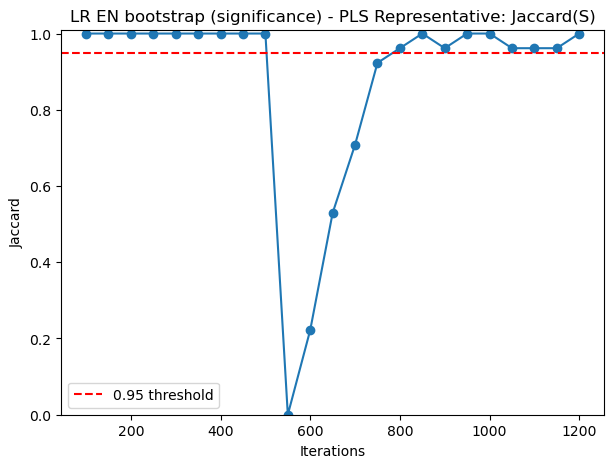

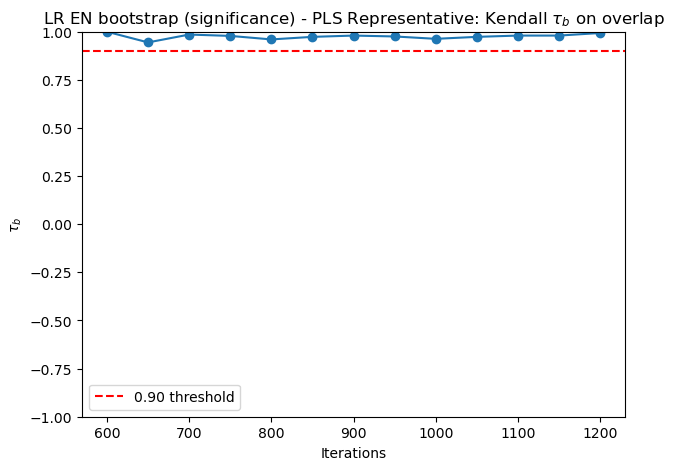

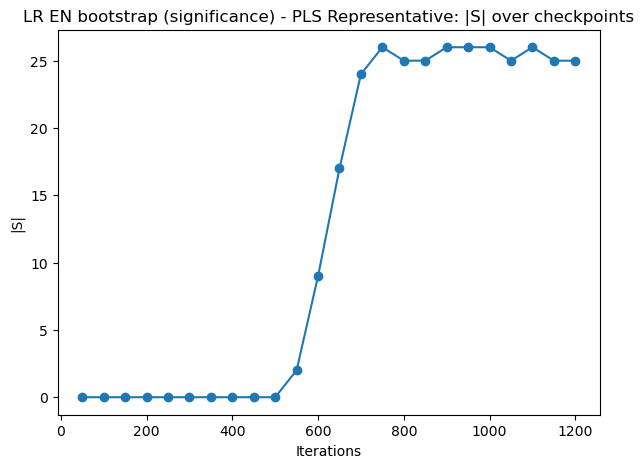

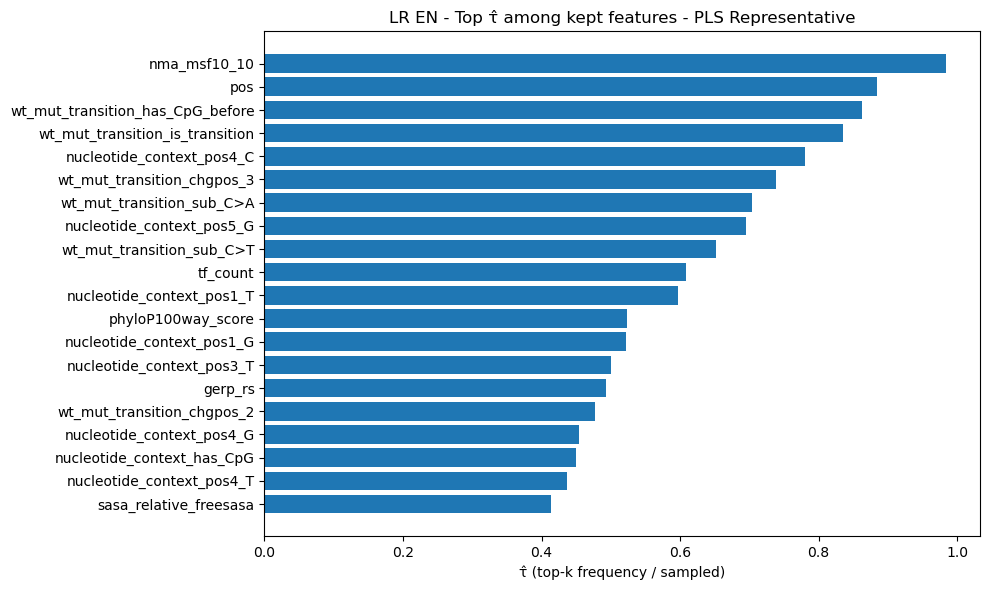

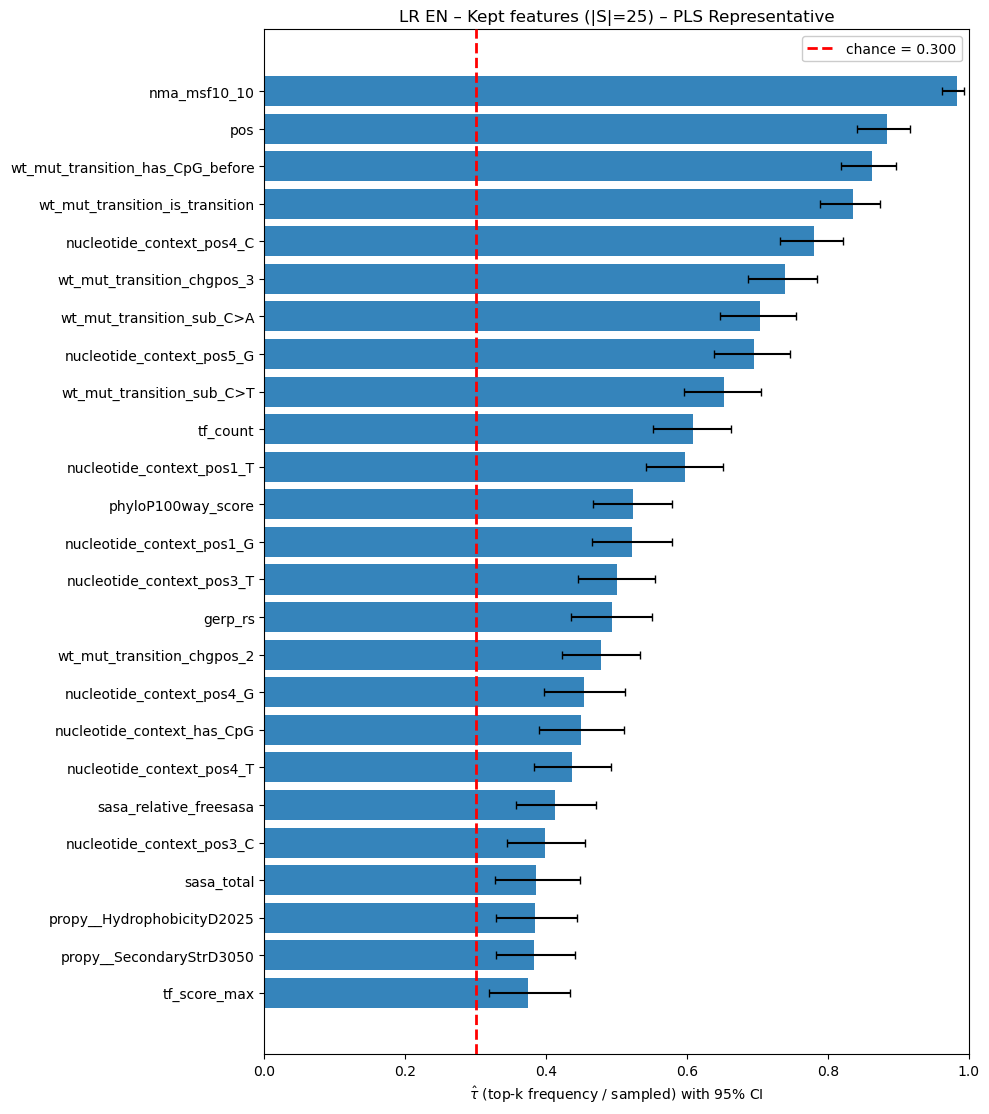

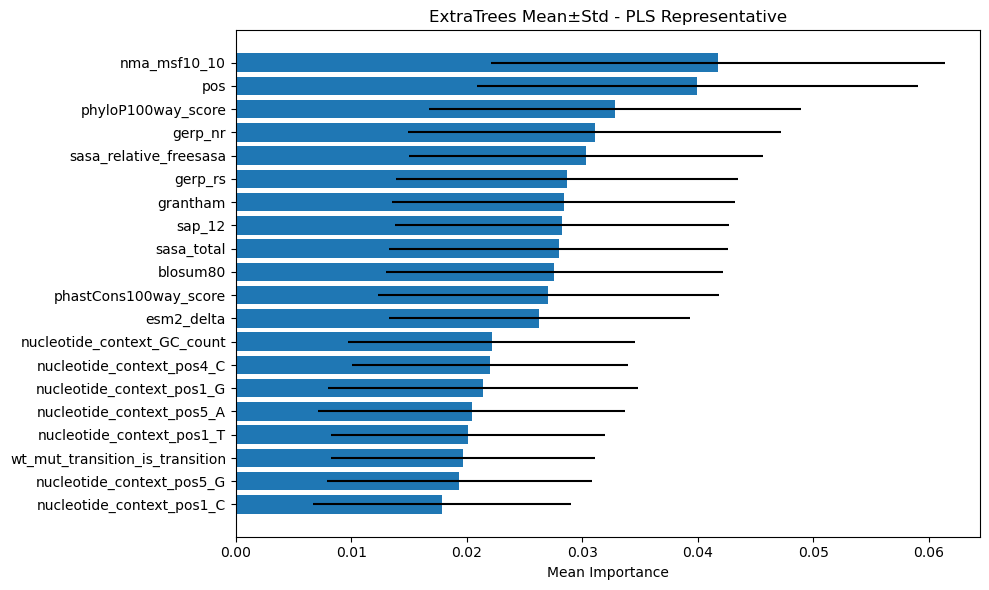

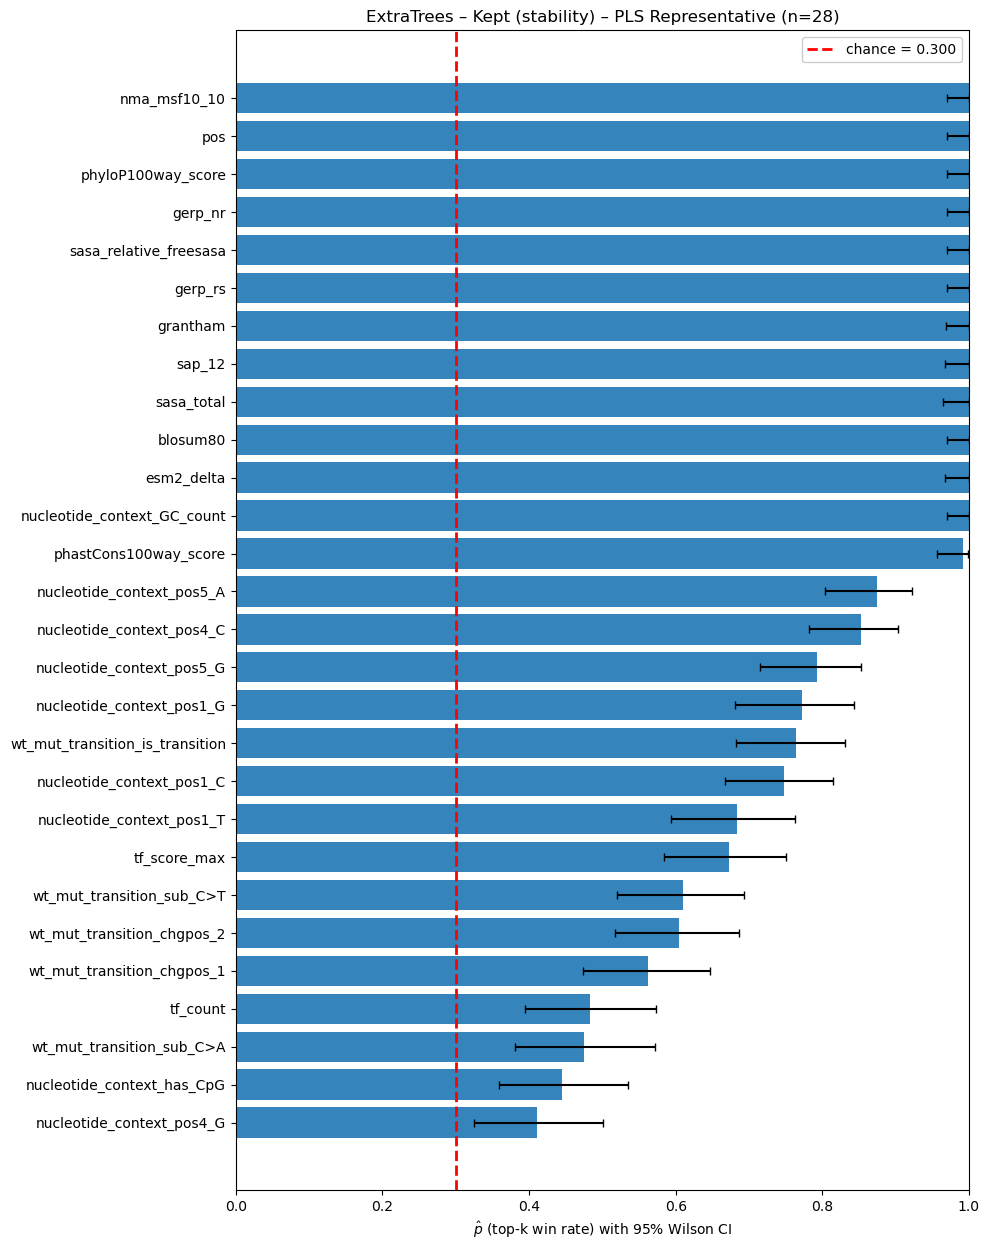

Validation AUC (permutation baseline): 0.518


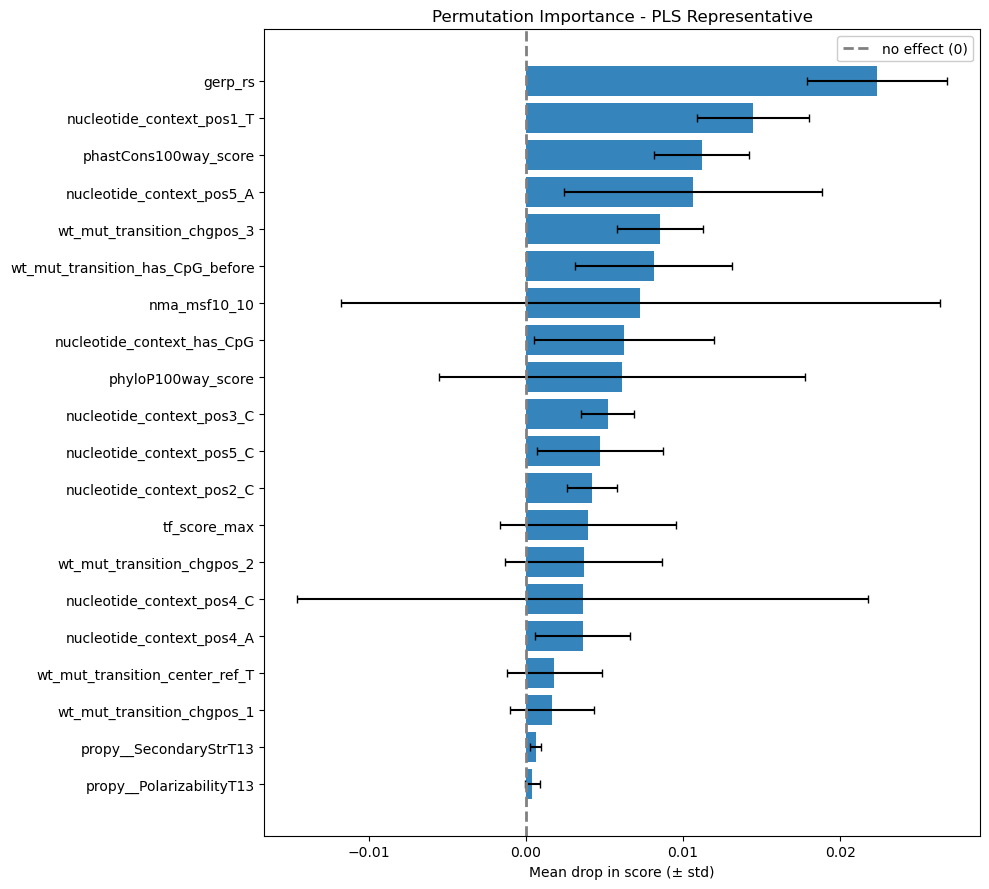

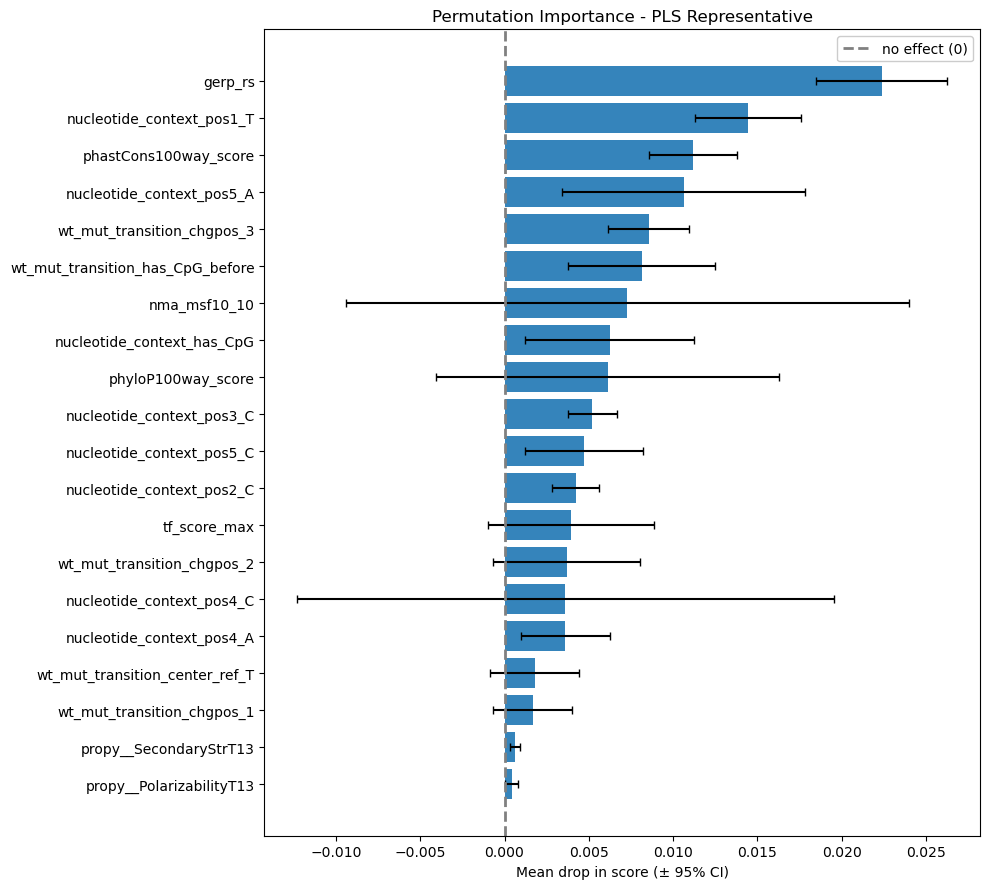

Validation AUC (LightGBM): 0.637


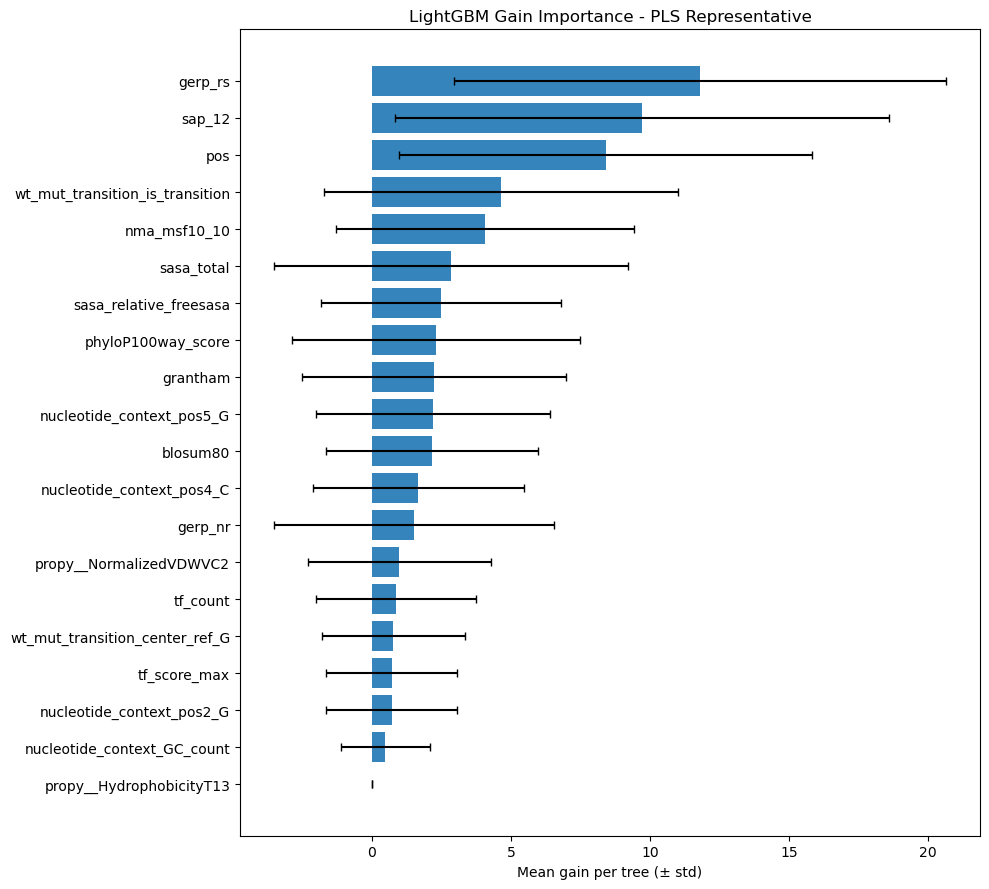

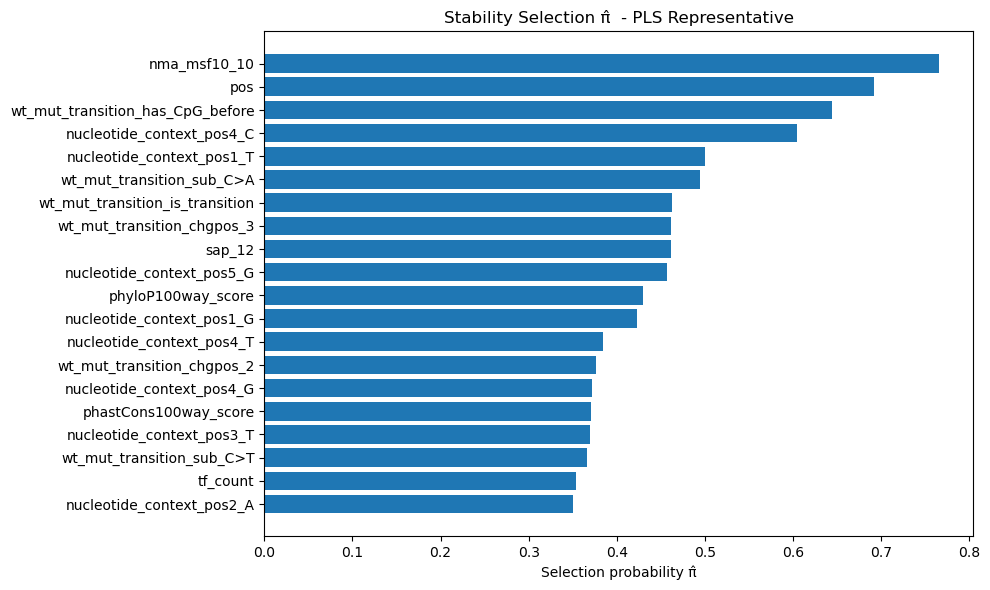

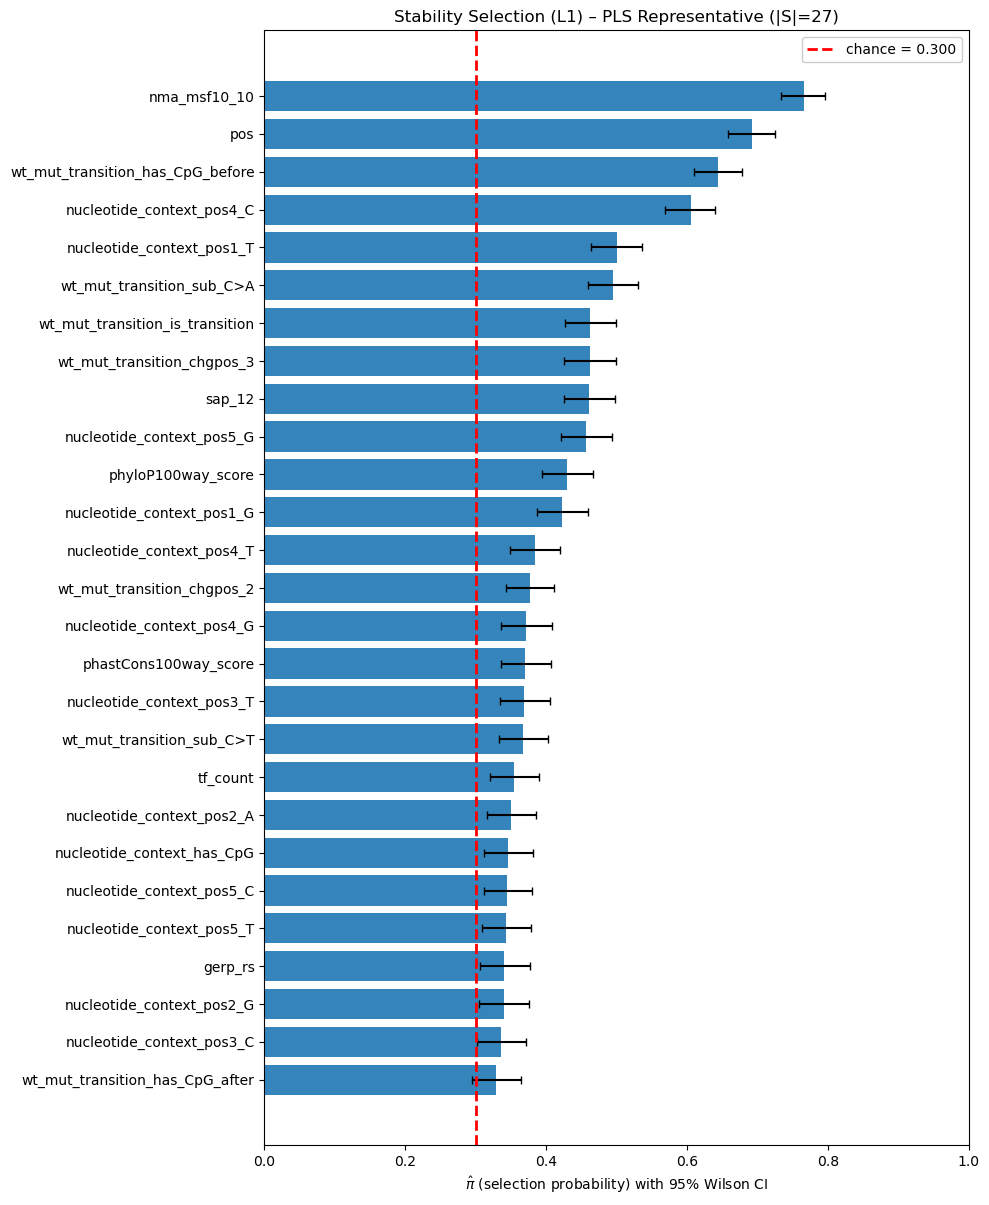

In [691]:
final_results = {}
for name, df_curr in datasets_to_test.items():
    experts, aux = run_all_experts_on(name, df_curr, y)
    consensus_feats, votes = vote_consensus(experts, min_votes=1)

    keep, pruned_df, pairs_df, corr_mat = corr_prune_with_report(
        df_curr,
        consensus_feats,
        thresh=0.90,
        aux=aux,
        votes=votes
    )

    final_results[name] = {
        'experts': experts,
        'consensus_raw': consensus_feats,
        'consensus_pruned': keep,
        'votes': votes,
        'aux': aux,
        'prune_report': pruned_df,
        'corr_pairs': pairs_df,
        'corr_matrix': corr_mat
    }

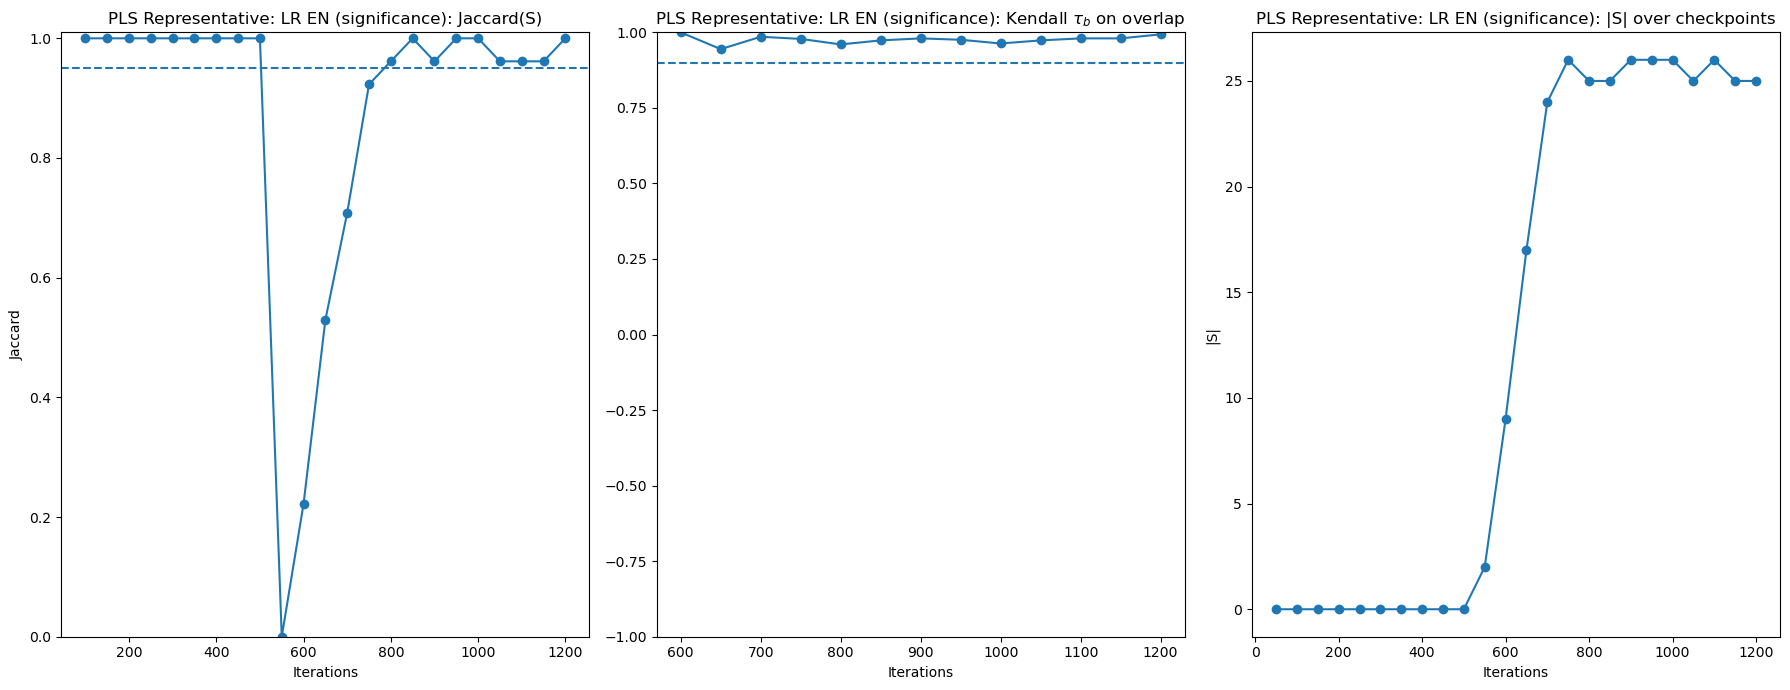

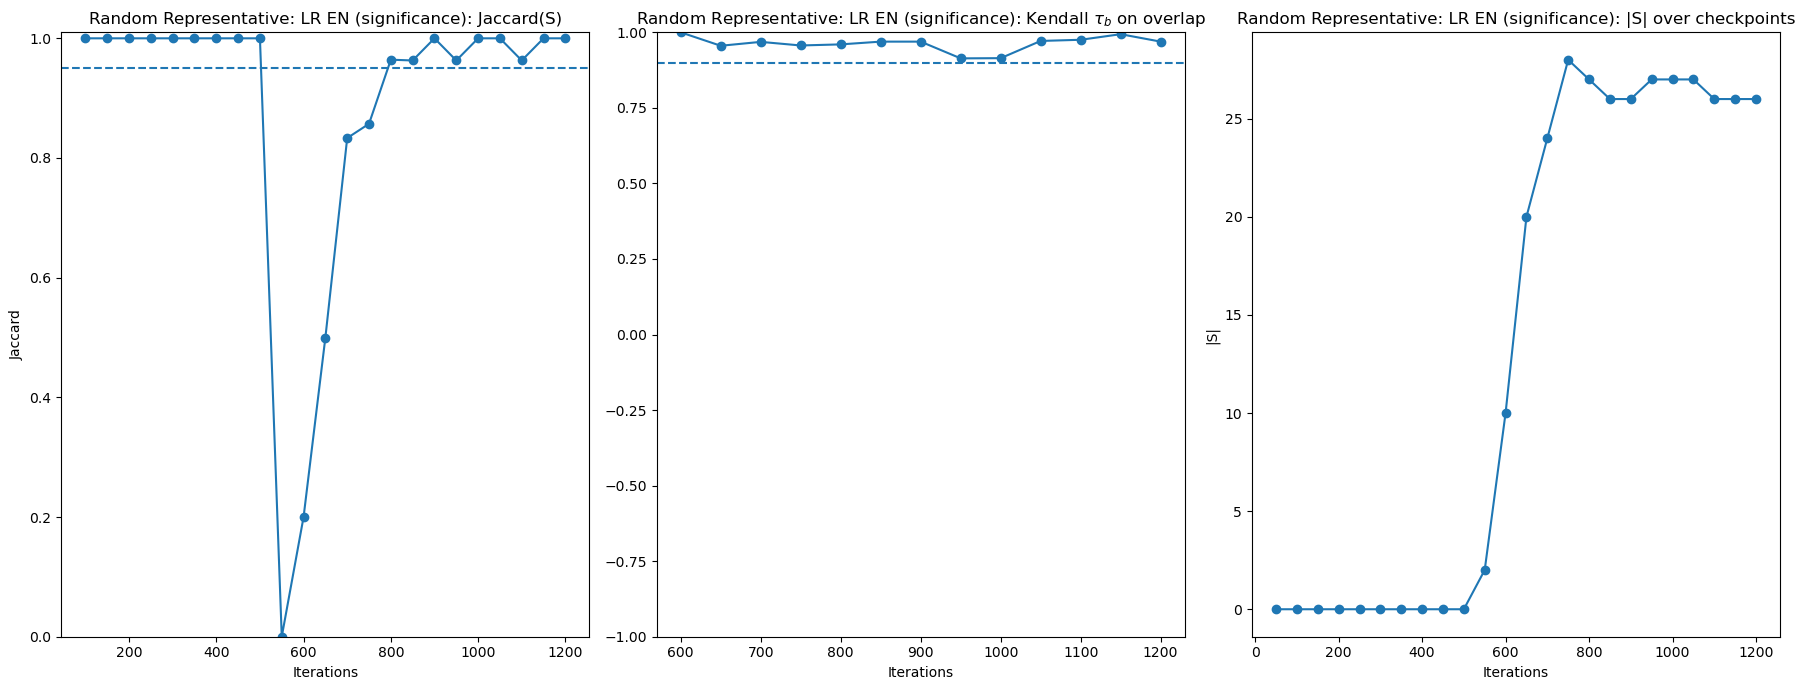

In [84]:
for name, res in final_results.items():
    hist = res['aux'].get('lr_hist')
    if hist and hist.get('iters'):
        plot_monitor_history_significance(hist, title_prefix=f"{name}: LR EN (significance)")
    else:
        print(f"[skip] No history for {name}")

In [85]:
features_lr = final_results['PLS Representative']['experts']['lr_sig']
features_et = final_results['PLS Representative']['experts']['et_meanstd']
features_perm = final_results['PLS Representative']['experts']['perm_rf']
features_stab = final_results['PLS Representative']['experts']['stabsel']
features_lgbm = final_results['PLS Representative']['experts']['lgbm_perm']

In [86]:
print(len(features_lr))
print(len(features_et))
print(len(features_perm))
print(len(features_stab))
print(len(features_lgbm))

25
28
20
27
27


In [ ]:
features_perm_rand = final_results['PLS Representative']['experts']['perm_rf']
features_perm_rand

['gerp_rs',
 'nucleotide_context_pos1_T',
 'phastCons100way_score',
 'nucleotide_context_pos5_A',
 'wt_mut_transition_chgpos_3',
 'wt_mut_transition_has_CpG_before',
 'nma_msf10_10',
 'nucleotide_context_has_CpG',
 'phyloP100way_score',
 'nucleotide_context_pos3_C',
 'nucleotide_context_pos5_C',
 'nucleotide_context_pos2_C',
 'tf_score_max',
 'wt_mut_transition_chgpos_2',
 'nucleotide_context_pos4_C',
 'nucleotide_context_pos4_A',
 'wt_mut_transition_center_ref_T',
 'wt_mut_transition_chgpos_1',
 'propy__SecondaryStrT13',
 'propy__PolarizabilityT13']

In [ ]:
for name, res in final_results.items():
    print(f"\n=== {name} ===")
    print(f"Kept ({len(res['consensus_pruned'])}): {', '.join(res['consensus_pruned'])}")
    if res['prune_report'].empty:
        print("No features pruned by correlation.")
    else:
        print("\nPruned due to |corr| ≥ 0.90 (kept ▸ pruned : corr):")
        for _, r in res['prune_report'].iterrows():
            print(f"  {r['kept']} ▸ {r['pruned']} : {r['corr']:.3f}")

    print("\nTop correlated pairs overall:")
    print(res['corr_pairs'].head().to_string(index=False))


=== PLS Representative ===
Kept (42): nma_msf10_10, gerp_rs, nucleotide_context_pos4_C, phyloP100way_score, pos, nucleotide_context_pos1_T, wt_mut_transition_chgpos_2, tf_count, nucleotide_context_has_CpG, wt_mut_transition_has_CpG_before, wt_mut_transition_chgpos_3, phastCons100way_score, wt_mut_transition_is_transition, wt_mut_transition_sub_C>T, nucleotide_context_pos3_C, nucleotide_context_pos4_G, tf_score_max, nucleotide_context_pos5_A, sap_12, wt_mut_transition_sub_C>A, sasa_total, gerp_nr, nucleotide_context_pos5_C, nucleotide_context_pos1_G, wt_mut_transition_chgpos_1, nucleotide_context_pos4_T, nucleotide_context_pos4_A, nucleotide_context_pos5_T, nucleotide_context_pos5_G, nucleotide_context_pos3_T, nucleotide_context_pos2_C, wt_mut_transition_center_ref_T, propy__SecondaryStrT13, nucleotide_context_pos2_A, nucleotide_context_pos2_G, propy__HydrophobicityD2025, nucleotide_context_pos1_C, esm2_delta, wt_mut_transition_has_CpG_after, blosum80, grantham, nucleotide_context_GC_c

In [88]:
print("\n" + "="*80)
print("FINAL SUMMARY OF CONSENSUS SETS (corr prune @ 0.9)")
print("="*80)
for name, res in final_results.items():
    raw = res['consensus_raw']; pruned = res['consensus_pruned']
    print(f"\n--- {name} ---")
    print(f"Consensus (raw): {len(raw)} features")
    print(", ".join(raw[:40]) + ("..." if len(raw) > 40 else ""))
    print(f"Consensus (pruned): {len(pruned)} features")
    print(", ".join(pruned))


FINAL SUMMARY OF CONSENSUS SETS (corr prune @ 0.9)

--- PLS Representative ---
Consensus (raw): 45 features
nma_msf10_10, pos, wt_mut_transition_has_CpG_before, wt_mut_transition_is_transition, nucleotide_context_pos4_C, wt_mut_transition_chgpos_3, wt_mut_transition_sub_C>A, nucleotide_context_pos5_G, wt_mut_transition_sub_C>T, tf_count, nucleotide_context_pos1_T, phyloP100way_score, nucleotide_context_pos1_G, nucleotide_context_pos3_T, gerp_rs, wt_mut_transition_chgpos_2, nucleotide_context_pos4_G, nucleotide_context_has_CpG, nucleotide_context_pos4_T, sasa_relative_freesasa, nucleotide_context_pos3_C, sasa_total, propy__HydrophobicityD2025, propy__SecondaryStrD3050, tf_score_max, gerp_nr, grantham, sap_12, blosum80, phastCons100way_score, esm2_delta, nucleotide_context_GC_count, nucleotide_context_pos5_A, nucleotide_context_pos1_C, wt_mut_transition_chgpos_1, nucleotide_context_pos5_C, nucleotide_context_pos2_C, nucleotide_context_pos4_A, wt_mut_transition_center_ref_T, propy__Secon

In [149]:
from pathlib import Path

def _slug(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9]+', '_', s).strip('_').lower()

def save_selected_feature_sets(final_results, datasets_to_test, 
                               names=('PLS Representative','Random Representative','Aggregated Features'),
                               out_dir='feature_sets'):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    saved = {}

    for name in names:
        if name not in final_results:
            print(f"{name!r} not found in final_results; skipping.")
            continue

        keep = list(final_results[name]['consensus_pruned'])
        pd.Series(keep, name='feature').to_csv(out_dir / f'{_slug(name)}_features.csv', index=False)
        saved[name] = keep

    return saved

saved_lists = save_selected_feature_sets(final_results, datasets_to_test)

In [76]:
vcf_df = pd.read_csv("vcf_annotated_input_for_eda_first_chunk.csv", nrows=1000)

In [77]:
vcf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 957 entries, GENE_SYMBOL to Entropy Complex
dtypes: float64(934), int64(3), object(20)
memory usage: 7.3+ MB


In [ ]:
pd.set_option('display.max_columns', None)  # Show all DataFrame columns
pd.set_option('display.max_rows', None)     # Show all rows

In [79]:
nan_percentage = vcf_df.isna().mean() * 100
print(nan_percentage.sort_values(ascending=False))

nma_rmsf10w                               100.0
nma_rmsf7w                                100.0
nma_rmsf3w                                 95.2
nma_rmsf5w                                 95.2
PolyPhen                                   60.5
SIFT                                       60.5
phi                                        56.8
psi                                        56.8
Van der Waals clashes                      56.8
Solvation Hydrophobic                      56.8
Solvation Polar                            56.8
Sidechain Hbond                            56.8
backbone clash                             56.8
torsional clash                            56.8
mloop_entropy                              56.8
sloop_entropy                              56.8
rASA                                       56.8
Electrostatics                             56.8
entropy mainchain                          56.8
entropy sidechain                          56.8
SD                                      

In [80]:
vcf_df.CLIN_SIG.unique()

array(['likely_benign', nan, 'uncertain_significance', 'benign',
       'uncertain_significance,likely_benign'], dtype=object)

Map "likely_benign" and "benign" to 0

In [68]:
vcf_df.head(20)

GENE_SYMBOL TRANSCRIPT_ACCESSION MUTATION_AA   Codons          HGVSG  \
0          OR4F5    ENST00000641515.X      p.E36G  gAa/gGa   1:g.69134A>G   
1            NaN    ENST00000641515.X      p.I96S  aTt/aGt   1:g.69314T>G   
2            NaN    ENSR00000918279.X         NaN      NaN      1:g.69314   
3          OR4F5    ENST00000641515.X     p.M132I  atG/atA   1:g.69423G>A   
4          OR4F5    ENSR00000918279.X         NaN      NaN      1:g.69423   
5          OR4F5    ENST00000641515.X     p.P185R  cCc/cGc   1:g.69581C>G   
6         SAMD11    ENST00000641515.X     p.V219M  Gtg/Atg   1:g.69682G>A   
7         SAMD11    ENST00000641515.X     p.I235T  aTc/aCc   1:g.69731T>C   
8         SAMD11    ENST00000641515.X     p.S248P  Tcc/Ccc   1:g.69769T>C   
9         SAMD11    ENST00000641515.X     p.S323T  aGt/aCt   1:g.69995G>C   
10        SAMD11    ENST00000341065.X         NaN      NaN     1:g.925946   
11        SAMD11    ENST00000342066.X       p.S2C  tCc/tGc  1:g.925946C>G   
12        SAMD11    ENST00000437963.X       p.S2C  tCc/tGc  1:g.925946C>G   
13  LOC107985728    ENST00000609207.X         NaN      NaN     1:g.925946   
14     LOC284600    ENST00000616016.X     p.S181C  tCc/tGc  1:g.925946C>G   
15     LOC284600    ENST00000616125.X       p.S2C  tCc/tGc  1:g.925946C>G   
16           NaN    ENST00000617307.X       p.S2C  tCc/tGc  1:g.925946C>G   
17        SAMD11    ENST00000618181.X       p.S2C  tCc/tGc  1:g.925946C>G   
18        SAMD11    ENST00000618323.X     p.S181C  tCc/tGc  1:g.925946C>G   
19        SAMD11    ENST00000618779.X       p.S2C  tCc/tGc  1:g.925946C>G   

                                                   TF  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ATF3,ATF7,BACH1...   
11  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ATF3,ATF7,BACH1...   
12  AGO1,ASH2L,BHLHE40,CREM,CTBP1,CTCF,DPF2,E2F6,E...   
13  AGO1,ASH2L,ATF7,CBFA2T3,CEBPB,CREB3L1,CTCF,DAC...   
14  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ASH2L,ATF3,ATF7...   
15  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ATF3,ATF7,BACH1...   
16  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ATF3,ATF7,BACH1...   
17  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ATF3,ATF7,BACH1...   
18  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ASH2L,ATF3,ATF7...   
19  AGO1,AGO2,ARHGAP35,ARID3A,ARNT,ATF3,ATF7,BACH1...   

                                             TF_SCORE  UNIPROT_ID  CHROMOSOME  \
0                                                 NaN         NaN           1   
1                                                 NaN         NaN           1   
2                                                 NaN         NaN           1   
3                                                 NaN         NaN           1   
4                                                 NaN         NaN           1   
5                                                 NaN         NaN           1   
6                                                 NaN         NaN           1   
7                                                 NaN         NaN           1   
8                                                 NaN         NaN           1   
9                                                 NaN         NaN           1   
10  10,17,29,33,41,50,53,57,58,67,68,76,78,79,83,9...      H7BY14           1   
11  10,17,29,33,41,50,53,57,58,67,68,76,78,79,83,9...      Q96NU1           1   
12  78,79,86,93,95,101,104,112,114,120,126,134,178...      Q5SV95           1   
13  11,19,27,43,55,58,99,112,119,132,133,139,144,1...  

For features phi and psi, the angular representation, we will use cos(phi) cos(psi) sin(phi) and sin(psi), then we get unique combinations for each protein. It also scales the data between 1 and -1. Learns that the angle that 0 and 360 are the same angle.

In [695]:
plot_perm_importance(imp_df, top_n=20, n_repeats=None, use_ci=True,
                         score_name="AUC",
                         title=None)

NameError: name 'imp_df' is not defined

In [698]:
plot_lgbm_gain_importance_ci(lgb_model, feature_names, top_n=20,
                                 score_name="AUC",
                                 title=None, annotate=True)

NameError: name 'lgb_model' is not defined

In [701]:
ds_name = "PLS Representative"

res = final_results[ds_name]
aux = res["aux"]          # all fitted models/importance tables are here
Xd  = datasets_to_test[ds_name]

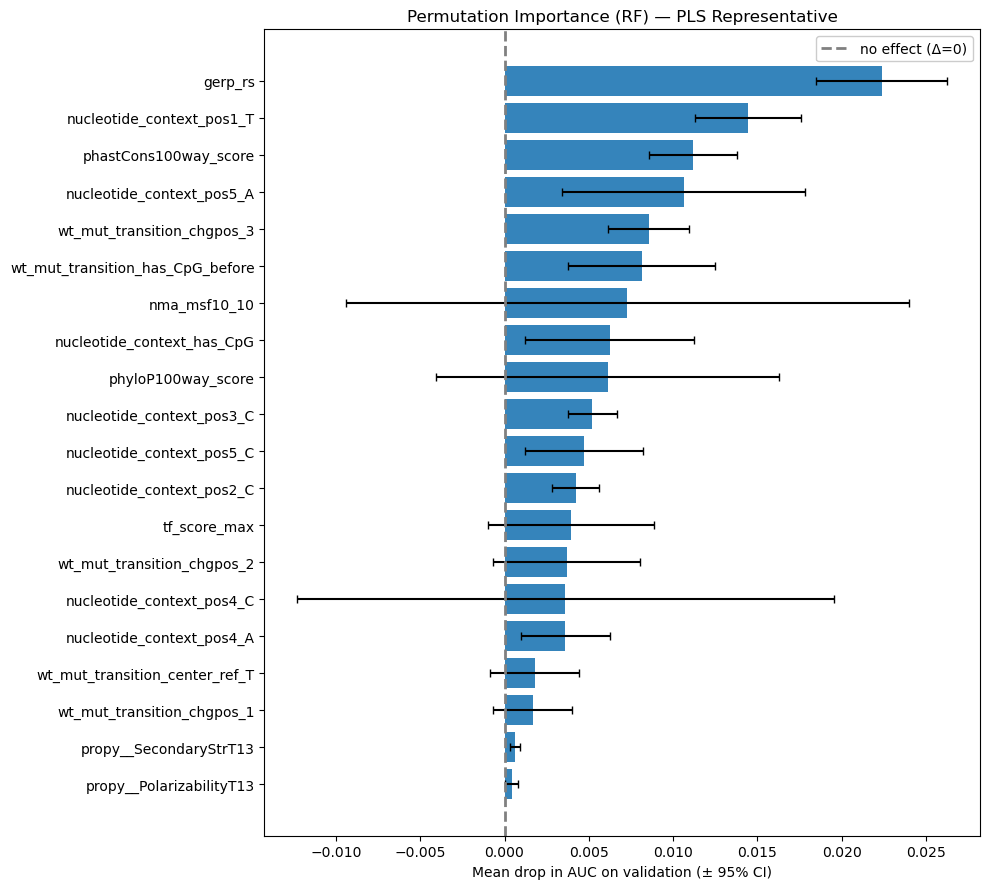

feature  mean_importance  std_importance
1                            gerp_rs         0.022361        0.004461
45         nucleotide_context_pos1_T         0.014444        0.003572
4              phastCons100way_score         0.011181        0.003006
58         nucleotide_context_pos5_A         0.010625        0.008207
66        wt_mut_transition_chgpos_3         0.008542        0.002722
78  wt_mut_transition_has_CpG_before         0.008125        0.004991
36                      nma_msf10_10         0.007292        0.019052
63        nucleotide_context_has_CpG         0.006250        0.005714
3                 phyloP100way_score         0.006111        0.011622
51         nucleotide_context_pos3_C         0.005208        0.001672
59         nucleotide_context_pos5_C         0.004722        0.003999
47         nucleotide_context_pos2_C         0.004236        0.001590
81                      tf_score_max         0.003958        0.005601
65        wt_mut_transition_chgpos_2         0.003681        0.004972
55         nucleotide_context_pos4_C         0.003611        0.018168
54         nucleotide_context_pos4_A         0.003611        0.003016
77    wt_mut_transition_center_ref_T         0.001806        0.003014
64        wt_mut_transition_chgpos_1         0.001667        0.002693
14            propy__SecondaryStrT13         0.000625        0.000340
12          propy__PolarizabilityT13         0.000417        0.000461

In [ ]:
perm_imp = aux["perm_imp_rf"]

plot_perm_importance(perm_imp, top_n=20,
                     title=f"Permutation Importance (RF) - {ds_name}",
                     n_repeats=5, use_ci=True)

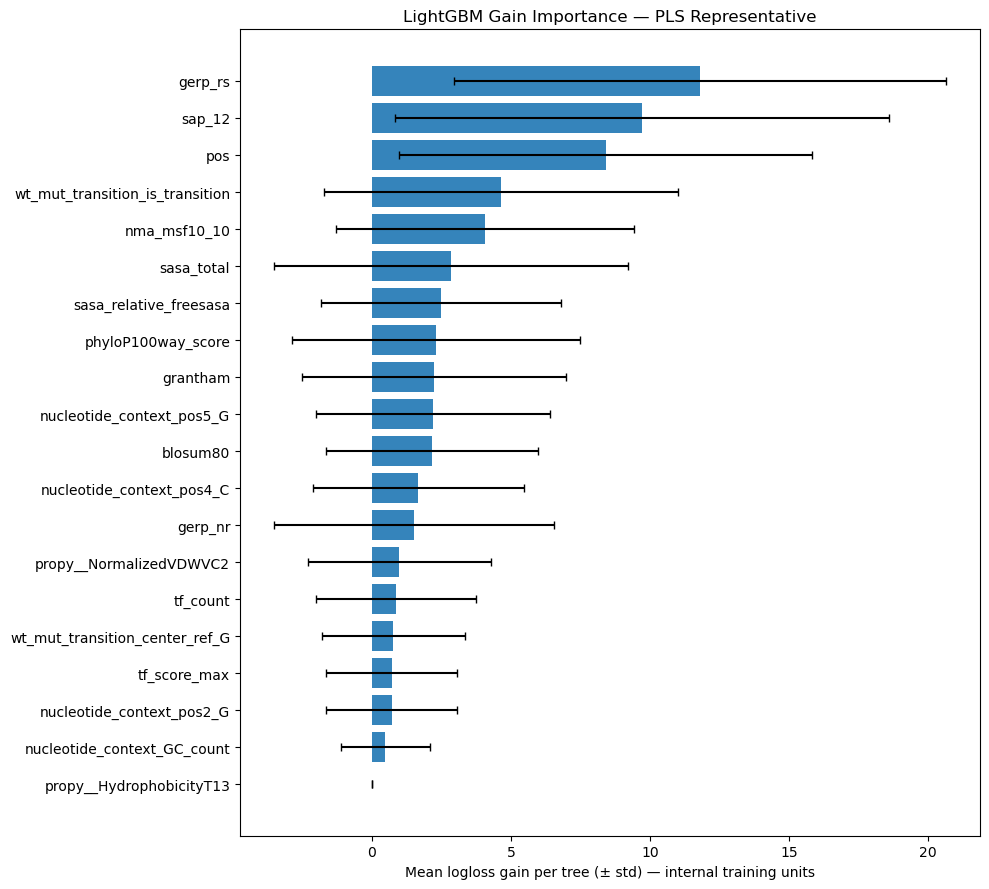

feature  gain_total  gain_mean  gain_std  n_trees
0                            gerp_rs  141.694800  11.807900  8.857829       12
1                             sap_12  116.471029   9.705919  8.882512       12
2                                pos  100.987739   8.415645  7.428275       12
3    wt_mut_transition_is_transition   55.903049   4.658587  6.367502       12
4                       nma_msf10_10   48.916309   4.076359  5.361543       12
..                               ...         ...        ...       ...      ...
78    wt_mut_transition_center_ref_C    0.000000   0.000000  0.000000       12
79  wt_mut_transition_has_CpG_before    0.000000   0.000000  0.000000       12
80   wt_mut_transition_has_CpG_after    0.000000   0.000000  0.000000       12
81    wt_mut_transition_multi_change    0.000000   0.000000  0.000000       12
82                           propy_M    0.000000   0.000000  0.000000       12

[83 rows x 5 columns]

In [ ]:
plot_lgbm_gain_importance_ci(
    aux["lgb_model"], Xd.columns, top_n=20,
    title=f"LightGBM Gain Importance - {ds_name}"
)